# Geotechnical Data Analysis & Visualization System


---

## Overview
This notebook processes comprehensive geotechnical laboratory testing data and generates standardized visualizations for engineering analysis. The system handles 14 different test types with unified data processing and dynamic column extraction.

## 1. System Setup & Configuration

Setting up the analysis environment with required libraries, functions, and output directories.

### 1.1 Required Libraries

Import essential libraries for data processing, visualization, and analysis.

In [9]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import warnings
import os
import re
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import MaxNLocator
from openpyxl import Workbook
from openpyxl.styles import Font, PatternFill, Alignment
from openpyxl.utils.dataframe import dataframe_to_rows

warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl")

### 1.2 Custom Functions

Import specialized geotechnical analysis and visualization functions:

**Data Processing Functions:**
- `parse_to_mm`: Convert sieve sizes to millimeters
- `merge_intervals`: Combine depth intervals for analysis
- `merge_geotech_data`: Integrate multiple data sources
- `Excel_writer`: Export data with formatting

**Visualization Functions:**
- `plot_atterberg_chart`: Plasticity classification charts
- `plot_psd`: Particle size distribution curves
- `plot_SPT_vs_depth_*`: Standard penetration test analysis
- `plot_UCS_*`: Unconfined compressive strength analysis
- `plot_*_histogram`: Statistical distribution plots
- `plot_by_chainage`: Spatial property variation
- `plot_engineering_property_vs_depth`: Depth-dependent trends

In [12]:
from Functions.Excel_writer import Excel_writer
from Functions.parse_to_mm import parse_to_mm
from Functions.plot_atterberg_chart import plot_atterberg_chart
from Functions.merge_intervals import merge_intervals
from Functions.plot_Su_histogram_matplotlib import plot_Su_histogram_matplotlib
from Functions.plot_effective_cohesion_histogram_matplotlib import plot_effective_cohesion_histogram_matplotlib
from Functions.plot_effective_c_phi_histograms import plot_effective_c_phi_histograms
from Functions.plot_CBR_swell_WPI_histogram import plot_CBR_swell_WPI_histogram
from Functions.plot_cbr_vs_consistency import plot_cbr_vs_consistency
from Functions.plot_UCS_Is50 import plot_UCS_Is50
from Functions.merge_geotech_data import merge_geotech_data
from Functions.plot_emerson_by_origin import plot_emerson_by_origin
from Functions.plot_psd import plot_psd
from Functions.plot_histogram import plot_histogram
from Functions.plot_UCS_vs_depth import plot_UCS_vs_depth
from Functions.plot_SPT_vs_depth_granular import plot_SPT_vs_depth_granular
from Functions.plot_SPT_vs_depth_cohesive import plot_SPT_vs_depth_cohesive
from Functions.plot_engineering_property_vs_depth import plot_engineering_property_vs_depth
from Functions.plot_category_by_thickness import plot_category_by_thickness
from Functions.plot_by_chainage import plot_by_chainage

In [14]:
# Dynamic column extraction function for all test types
def extract_test_columns(df, test_name):
    """Extract data columns for a specific test type following the standard pattern"""
    identifier_col = f"{test_name}?"
    if identifier_col not in df.columns:
        return []
    
    # Find the position of the identifier column
    all_cols = df.columns.tolist()
    start_idx = all_cols.index(identifier_col) + 1
    
    # Find the next identifier column to determine where this test's columns end
    end_idx = len(all_cols)
    for i in range(start_idx, len(all_cols)):
        if all_cols[i].endswith('?'):
            end_idx = i
            break
    
    return all_cols[start_idx:end_idx]

# Function to create test dataframe with identifier column included
def create_test_dataframe(df, test_name, id_columns, data_columns):
    """Create a test-specific dataframe including the test identifier column"""
    condition = df[f'{test_name}?'] == 'Y'
    # Include the test identifier column along with ID and data columns
    columns_to_include = id_columns + [f'{test_name}?'] + data_columns
    return df[condition][columns_to_include]

### 1.3 Project Configuration

Configure analysis parameters, timestamps, and output directories.

#### 1.3.1 Timestamp Generation

Generate timestamp for output folder organization.

In [18]:
now = dt.datetime.now()
year = now.year
month = now.month
day = now.day
hour = now.hour

#### 1.3.2 Directory Structure

Set up input and output directory paths with timestamped organization.

In [21]:
input_folder = f'Input'
output_folder = f'Output/{year}{month}{day}_{hour}h'
os.makedirs(output_folder,exist_ok=True)

## 2. Data Loading & Processing

Load and process the complete geotechnical laboratory testing dataset with integrated test types.

In [ ]:
# Load the complete lab testing dataset
Lab_summary_final = pd.read_excel("Lab_summary_final.xlsx")
print(f"Lab testing data loaded: {Lab_summary_final.shape[0]} rows, {Lab_summary_final.shape[1]} columns")
Lab_summary_final['Geology_Orgin'] = Lab_summary_final['Geology_Orgin'].replace('Residual to Extreme Weathered', 'RS_XW')
Lab_summary_final['Consistency'].unique()

In [ ]:
# Define standard ID columns used across all test types
ID_column_list = ['Hole_ID', 'Type', 'From_mbgl', 'To_mbgl', 'Chainage', 'Surface RL (m AHD)', 
                  'BH Depth (m)', 'Geology_Orgin', 'Map_symbol', 'Consistency', 'Report']

# Extract column lists for all test types using unified method
column_list_Atterberg = extract_test_columns(Lab_summary_final, 'Atterberg')
column_list_CBR = extract_test_columns(Lab_summary_final, 'CBR')
column_list_PSD = extract_test_columns(Lab_summary_final, 'PSD')
column_list_Shrink_Swell = extract_test_columns(Lab_summary_final, 'Shrink_Swell')
column_list_Compaction = extract_test_columns(Lab_summary_final, 'Compaction')
column_list_hydrometer = extract_test_columns(Lab_summary_final, 'Hydrometer')
column_list_Triaxial = extract_test_columns(Lab_summary_final, 'Triaxial')
column_list_Oedometer = extract_test_columns(Lab_summary_final, 'Oedometer')
column_list_Durability_Test = extract_test_columns(Lab_summary_final, 'Durability_Test')
column_list_UCS = extract_test_columns(Lab_summary_final, 'UCS')
column_list_Is_50 = extract_test_columns(Lab_summary_final, 'Is_50')
column_list_SPT = extract_test_columns(Lab_summary_final, 'SPT')

# Display summary of available test types and data
test_types = [col.replace('?', '') for col in Lab_summary_final.columns if col.endswith('?')]
print(f"✅ Found {len(test_types)} test types: {test_types}")

print("\nTest data summary:")
for test_type in test_types:
    test_count = (Lab_summary_final[f'{test_type}?'] == 'Y').sum()
    print(f"  {test_type}: {test_count} records")

print("✅ Column extraction completed successfully!")

Lab testing data loaded: 2459 rows, 167 columns
✅ Found 14 test types: ['Atterberg', 'Shrink_Swell', 'Emerson', 'CBR', 'Compaction', 'Oedometer', 'Durability_Test', 'Triaxial', 'PSD', 'WPI', 'Hydrometer', 'UCS', 'Is_50', 'SPT']

Test data summary:
  Atterberg: 279 records
  Shrink_Swell: 2 records
  Emerson: 44 records
  CBR: 76 records
  Compaction: 80 records
  Oedometer: 11 records
  Durability_Test: 60 records
  Triaxial: 33 records
  PSD: 309 records
  WPI: 227 records
  Hydrometer: 10 records
  UCS: 162 records
  Is_50: 1817 records
  SPT: 220 records
✅ Column extraction completed successfully!


### 2.1 Individual Test Dataset Extraction

Extract test-specific datasets from the integrated lab summary using dynamic column detection.

**Data Structure:**
- **14 test types** with unified "TestName?" identifier pattern
- **Dynamic column extraction** using `extract_test_columns()` function  
- **Clean test indicators**: 'Y' for actual tests, NaN for no tests
- **Preserved identifiers**: Each dataset includes its test identifier column
- **Complete integration**: SPT data merged from external source

**Test Types Available:**
Atterberg | Shrink_Swell | Emerson | CBR | Compaction | Oedometer | Durability_Test | Triaxial | PSD | WPI | Hydrometer | UCS | Is_50 | SPT

In [15]:
# Create all test dataframes using the unified extraction method
SPT = create_test_dataframe(Lab_summary_final, 'SPT', ID_column_list, column_list_SPT)

# Load BH_Interpretation data (if available)
try:
    BH_Interpretation = pd.read_excel("Input/BH_Interpretation.xlsx")
    print(f"BH_Interpretation data loaded successfully: {BH_Interpretation.shape}")
except FileNotFoundError:
    print("Warning: Input/BH_Interpretation.xlsx not found")
    BH_Interpretation = pd.DataFrame(columns=['Hole_ID', 'From_mbgl', 'To_mbgl', 'Thickness', 
                                            'Geology_Orgin', 'Consistency', 'Report'])
except Exception as e:
    print(f"Warning: Could not load BH_Interpretation data: {e}")
    BH_Interpretation = pd.DataFrame(columns=['Hole_ID', 'From_mbgl', 'To_mbgl', 'Thickness', 
                                            'Geology_Orgin', 'Consistency', 'Report'])


BH_Interpretation data loaded successfully: (1893, 7)


#### 2.1.1 Atterberg Limits Testing

Extract Atterberg limits data (liquid limit, plastic limit, plasticity index, linear shrinkage).

In [17]:
Atterberg_final = create_test_dataframe(Lab_summary_final, 'Atterberg', ID_column_list, column_list_Atterberg)

#### 2.1.2 Moisture Content Analysis

Extract and consolidate moisture content data from various test sources.

In [19]:
Lab_summary_final.columns.to_list()
Moisture_column = [i for i in Lab_summary_final.columns.to_list() if "MC" in i]
if 'OMC (%)' in Moisture_column:
    Moisture_column.remove('OMC (%)')
Moisture_column 

['MC (%) - from Atterberg test',
 'MC before Swell Test (%)',
 'MC (%) - from CBR test',
 'Initial MC (%)',
 'MC(%) from Durability Test']

In [20]:
Moisture_Cont = Lab_summary_final[ID_column_list + Moisture_column]
Moisture_Cont = Moisture_Cont.dropna(how='all', subset=Moisture_column)
Moisture_Cont.insert(loc= len(ID_column_list), column='MC_%', value=Moisture_Cont.bfill(axis=1).iloc[:, 11])
Moisture_Cont

Hole_ID Type  From_mbgl  To_mbgl  Chainage Surface RL (m AHD)  \
3     ARU-K-AH06   AH        2.7      NaN   21200.0              49.44   
5     ARU-K-AH17   AH        1.2      NaN   22000.0              54.99   
11    ARU-K-AH21   AH        1.2      NaN   22200.0              45.85   
14    ARU-K-AH22   AH        1.2      NaN   22100.0              52.79   
17    ARU-K-AH24   AH        4.2      NaN   22200.0              46.32   
...          ...  ...        ...      ...       ...                ...   
2454       TP-77   TP        1.5      2.0   36950.0               8.48   
2455       TP-78   TP        1.6      1.9   37050.0               8.99   
2456       TP-79   TP        0.2      0.5   37810.0               6.03   
2457       TP-80   TP        0.5      0.8   38110.0               9.92   
2458       TP-81   TP        0.8      1.0   38910.0              12.55   

      BH Depth (m) Geology_Orgin Map_symbol Consistency  \
3              NaN         RS_XW       Toce           H   
5              NaN         RS_XW       RJbw         VSt   
11             NaN      ALLUVIUM        Tos          St   
14             NaN         RS_XW        Tos          St   
17             NaN         RS_XW        Tos         VSt   
...            ...           ...        ...         ...   
2454           2.0          FILL     Qhh/re           H   
2455           2.0          FILL        DCf           L   
2456           2.0          FILL        DCf           S   
2457           2.0         RS_XW        DCf          St   
2458           1.8          FILL        Qhh          MD   

                     Report  MC_%  MC (%) - from Atterberg test  \
3           ARUP Kuraby GFR  18.6                          18.6   
5           ARUP Kuraby GFR   9.6                           9.6   
11          ARUP Kuraby GFR  23.8                          23.8   
14          ARUP Kuraby GFR  18.2                          18.2   
17          ARUP Kuraby GFR  16.3                          16.3   
...                     ...   ...                           ...   
2454  DTMR GFR_FG23024-R4.0  11.9                          11.9   
2455  DTMR GFR_FG23024-R4.0  12.3                          12.3   
2456  DTMR GFR_FG23024-R4.0  21.6                          21.6   
2457  DTMR GFR_FG23024-R4.0  27.2                          27.2   
2458  DTMR GFR_FG23024-R4.0   7.2                           7.2   

      MC before Swell Test (%)  MC (%) - from CBR test  Initial MC (%)  \
3                          NaN                     NaN             NaN   
5                          NaN                     NaN             NaN   
11                         NaN                     NaN             NaN   
14                         NaN                     NaN             NaN   
17                         NaN                     NaN             NaN   
...                        ...                     ...             ...   
2454                       NaN                    11.9             NaN   
2455                       NaN                    12.3             NaN   
2456                       NaN                     NaN             NaN   
2457                       NaN                     NaN             NaN   
2458                       NaN                     7.2             NaN   

     MC(%) from Durability Test  
3                           NaN  
5                           NaN  
11                          NaN  
14                          NaN  
17                          NaN  
...                         ...  
2454                        NaN  
2455                        NaN  
2456                        NaN  
2457                        1.7  
2458                        NaN  

[325 rows x 17 columns]

#### 2.1.3 Shrinkage & Swelling Properties

In [22]:
Shrink_Swell_final = create_test_dataframe(Lab_summary_final, 'Shrink_Swell', ID_column_list, column_list_Shrink_Swell)

#### 2.1.4 Emerson Class Testing

In [24]:
Emerson_final = create_test_dataframe(Lab_summary_final, 'Emerson', ID_column_list, ['Emerson'])

#### 2.1.5 California Bearing Ratio (CBR) Testing

In [26]:
CBR_final = create_test_dataframe(Lab_summary_final, 'CBR', ID_column_list, column_list_CBR)

#### 2.1.6 Compaction Properties

In [28]:
Compaction_final = create_test_dataframe(Lab_summary_final, 'Compaction', ID_column_list, column_list_Compaction)

#### 2.1.7 Hydrometer Analysis

In [30]:
hydrometer_final = create_test_dataframe(Lab_summary_final, 'Hydrometer', ID_column_list, column_list_hydrometer)
hydrometer_final

Hole_ID Type  From_mbgl  To_mbgl  Chainage Surface RL (m AHD)  \
63    ARU-K-BH03   BH       1.00     1.43   22100.0              48.86   
80    ARU-K-BH04   BH       1.00     1.45   22100.0              49.01   
103   ARU-K-BH05   BH      14.00    14.38   22100.0              48.97   
124   ARU-K-TP04   TP       0.03     0.20   21500.0               53.6   
134   ARU-K-TP08   TP       0.04     0.15   22100.0              55.73   
139   ARU-K-TP10   TP       0.35     0.70   22000.0              50.91   
144   ARU-K-TP12   TP       0.50     1.90   21300.0              50.19   
195        BH-03   BH       2.00     2.45   24020.0              37.13   
2332    SR-OL-02   BH       1.50     1.95   33930.0               12.2   
2333    SR-OL-02   BH       4.50     4.85   33930.0               12.2   

      BH Depth (m)                  Geology_Orgin Map_symbol Consistency  ...  \
63             NaN                          RS_XW        Tos          St  ...   
80             NaN                          RS_XW        Tos           F  ...   
103            NaN                          RS_XW        Tos          VD  ...   
124            NaN                           FILL       Toce         NaN  ...   
134            NaN                           FILL        Tos         NaN  ...   
139            NaN                       ALLUVIUM        Tos         VSt  ...   
144            NaN                       ALLUVIUM       Toce           F  ...   
195          12.52  Residual to Extreme Weathered      Qha/1           H  ...   
2332         17.10                       ALLUVIUM        DCf          St  ...   
2333         17.10                       ALLUVIUM        DCf          St  ...   

     0.056 0.050  0.047  0.046  0.040  0.039  0.036  0.033  0.032  0.030  
63     NaN  41.0    NaN    NaN    NaN    NaN   39.0    NaN    NaN    NaN  
80     NaN   NaN   62.0    NaN    NaN    NaN    NaN   60.0    NaN    NaN  
103    8.0   NaN    NaN    NaN    NaN    8.0    NaN    NaN    NaN    NaN  
124    NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    0.2  
134    NaN   NaN    NaN    NaN   0.15    NaN    NaN    NaN    NaN    NaN  
139    NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
144    NaN   NaN    NaN   55.0    NaN    NaN    NaN    NaN   54.0    NaN  
195    NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
2332   NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
2333   NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  

[10 rows x 48 columns]

#### 2.1.8 Particle Size Distribution (PSD)

In [32]:
PSD_final = create_test_dataframe(Lab_summary_final, 'PSD', ID_column_list, column_list_PSD)
PSD_final[PSD_final['Hole_ID'] == 'ARU-K-BH04']

Hole_ID Type  From_mbgl  To_mbgl  Chainage Surface RL (m AHD)  \
80  ARU-K-BH04   BH        1.0     1.45   22100.0              49.01   

    BH Depth (m) Geology_Orgin Map_symbol Consistency  ... 19mm 26.5mm  \
80           NaN         RS_XW        Tos           F  ...  NaN    NaN   

    31.5mm  37.5mm  53mm  63mm  75mm  100mm  150mm  200mm  
80     NaN     NaN   NaN   NaN   NaN    NaN    NaN    NaN  

[1 rows x 35 columns]

#### 2.1.9 Weathering Plasticity Index (WPI)

In [34]:
WPI_final = create_test_dataframe(Lab_summary_final, 'WPI', ID_column_list, ['WPI'])

#### 2.1.10 Triaxial Testing

In [36]:
Triaxial_final = create_test_dataframe(Lab_summary_final, 'Triaxial', ID_column_list, column_list_Triaxial)

#### 2.1.11 Oedometer (Consolidation) Testing

In [38]:
Oedometer_final = create_test_dataframe(Lab_summary_final, 'Oedometer', ID_column_list, column_list_Oedometer)

#### 2.1.12 Durability Testing

In [40]:
Durability_Test_final = create_test_dataframe(Lab_summary_final, 'Durability_Test', ID_column_list, column_list_Durability_Test)

#### 2.1.13 Unconfined Compressive Strength (UCS)

In [42]:
UCS_final = create_test_dataframe(Lab_summary_final, 'UCS', ID_column_list, column_list_UCS)

#### 2.1.14 Point Load Index Testing (Is_50)

In [44]:
Is_50_final = create_test_dataframe(Lab_summary_final, 'Is_50', ID_column_list, column_list_Is_50)

### 2.2 Data Export

Export individual test datasets to Excel files with proper formatting for further analysis.

In [46]:
# Excel_writer(Emerson_final, f"{output_folder}/Emerson.xlsx")
# Excel_writer(CBR_final, f"{output_folder}/CBR.xlsx")
# Excel_writer(Compaction_final, f"{output_folder}/Compaction.xlsx")
# Excel_writer(Shrink_Swell_final, f"{output_folder}/Shrink_Swell.xlsx")
# Excel_writer(hydrometer_final, f"{output_folder}/Hydrometer.xlsx")
# Excel_writer(PSD_final, f"{output_folder}/PSD.xlsx")
# Excel_writer(WPI_final, f"{output_folder}/WPI.xlsx")
# Excel_writer(Triaxial_final, f"{output_folder}/Triaxial.xlsx")
# Excel_writer(Oedometer_final, f"{output_folder}/Oedometer.xlsx")
# Excel_writer(SPT, f"{output_folder}/SPT.xlsx")
# Excel_writer(Durability_Test_final, f"{output_folder}/Durability_Test.xlsx")
# Excel_writer(UCS_final, f"{output_folder}/UCS.xlsx")
# Excel_writer(Is_50_final, f"{output_folder}/Is_50.xlsx")
# Excel_writer(Atterberg_final, f"{output_folder}/Atterberg.xlsx")

# print("✅ All individual test datasets exported successfully!")
# print(f"📁 Output location: {output_folder}")
# print(f"📊 Total datasets exported: 14")
# print(f"🔍 All datasets include test identifier columns for traceability")

## 3. Geotechnical Interpretive Report (GIR) Analysis

Generate comprehensive visualization and analysis suite for geotechnical interpretation and engineering design.

### 3.1 Particle Size Distribution Analysis

Comprehensive PSD analysis by geological origin and soil consistency for material classification.

#### 3.1.1 Alluvium Materials

PSD characteristics of alluvial deposits for foundation design considerations.

In [50]:
hydrometer_final.reset_index(drop=True)

Hole_ID Type  From_mbgl  To_mbgl  Chainage Surface RL (m AHD)  \
0  ARU-K-BH03   BH       1.00     1.43   22100.0              48.86   
1  ARU-K-BH04   BH       1.00     1.45   22100.0              49.01   
2  ARU-K-BH05   BH      14.00    14.38   22100.0              48.97   
3  ARU-K-TP04   TP       0.03     0.20   21500.0               53.6   
4  ARU-K-TP08   TP       0.04     0.15   22100.0              55.73   
5  ARU-K-TP10   TP       0.35     0.70   22000.0              50.91   
6  ARU-K-TP12   TP       0.50     1.90   21300.0              50.19   
7       BH-03   BH       2.00     2.45   24020.0              37.13   
8    SR-OL-02   BH       1.50     1.95   33930.0               12.2   
9    SR-OL-02   BH       4.50     4.85   33930.0               12.2   

   BH Depth (m)                  Geology_Orgin Map_symbol Consistency  ...  \
0           NaN                          RS_XW        Tos          St  ...   
1           NaN                          RS_XW        Tos           F  ...   
2           NaN                          RS_XW        Tos          VD  ...   
3           NaN                           FILL       Toce         NaN  ...   
4           NaN                           FILL        Tos         NaN  ...   
5           NaN                       ALLUVIUM        Tos         VSt  ...   
6           NaN                       ALLUVIUM       Toce           F  ...   
7         12.52  Residual to Extreme Weathered      Qha/1           H  ...   
8         17.10                       ALLUVIUM        DCf          St  ...   
9         17.10                       ALLUVIUM        DCf          St  ...   

  0.056 0.050  0.047  0.046  0.040  0.039  0.036  0.033  0.032  0.030  
0   NaN  41.0    NaN    NaN    NaN    NaN   39.0    NaN    NaN    NaN  
1   NaN   NaN   62.0    NaN    NaN    NaN    NaN   60.0    NaN    NaN  
2   8.0   NaN    NaN    NaN    NaN    8.0    NaN    NaN    NaN    NaN  
3   NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    0.2  
4   NaN   NaN    NaN    NaN   0.15    NaN    NaN    NaN    NaN    NaN  
5   NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
6   NaN   NaN    NaN   55.0    NaN    NaN    NaN    NaN   54.0    NaN  
7   NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
8   NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
9   NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  

[10 rows x 48 columns]

In [51]:
PSD_Hydrometer = PSD_final.merge(right=hydrometer_final, how='outer', on=ID_column_list)
PSD_Hydrometer.head(3)

Hole_ID Type  From_mbgl  To_mbgl  Chainage Surface RL (m AHD)  \
0  ARU-K-AH05   AH        1.0     1.45   21200.0              49.04   
1  ARU-K-AH06   AH        2.5     2.93   21200.0              49.44   
2  ARU-K-AH17   AH        1.0     1.45   22000.0              54.99   

   BH Depth (m) Geology_Orgin Map_symbol Consistency  ... 0.056 0.050  0.047  \
0           NaN      ALLUVIUM       Toce          St  ...   NaN   NaN    NaN   
1           NaN         RS_XW       Toce           H  ...   NaN   NaN    NaN   
2           NaN         RS_XW       RJbw         VSt  ...   NaN   NaN    NaN   

   0.046  0.040  0.039  0.036  0.033  0.032  0.030  
0    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
1    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
2    NaN    NaN    NaN    NaN    NaN    NaN    NaN  

[3 rows x 72 columns]

In [52]:
PSD_Hydrometer.columns

Index(['Hole_ID', 'Type', 'From_mbgl', 'To_mbgl', 'Chainage',
       'Surface RL (m AHD)', 'BH Depth (m)', 'Geology_Orgin', 'Map_symbol',
       'Consistency', 'Report', 'PSD?', '0.075 mm', '0.15mm', '0.212mm',
       '0.3mm', '0.425mm', '0.6mm', '1.18mm', '2.36mm', '4.75mm', '6.7mm',
       '9.5mm', '13.2mm', '16mm', '19mm', '26.5mm', '31.5mm', '37.5mm', '53mm',
       '63mm', '75mm', '100mm', '150mm', '200mm', 'Hydrometer?',
       'Soil Particle Density (t/m3)', '0.001', '0.002', '0.003', '0.005',
       '0.006', '0.007', '0.009', '0.01', '0.013', '0.014', '0.017', '0.021',
       '0.025', '0.029', '0.03', '0.035', '0.041', '0.042', '0.049', '0.057',
       '0.06', '0.068', '0.071', '0.066', '0.064', '0.056', '0.050', '0.047',
       '0.046', '0.040', '0.039', '0.036', '0.033', '0.032', '0.030'],
      dtype='object')

In [53]:
PSD_long_format = PSD_Hydrometer.melt(id_vars=ID_column_list+['PSD?', 'Hydrometer?', 'Soil Particle Density (t/m3)'], 
                                 var_name='Sieve Size', 
                                 value_name='Percentage passing (%)')
PSD_long_format = PSD_long_format.dropna(subset=['Percentage passing (%)'])
PSD_long_format['Sieve_Size_mm'] = PSD_long_format['Sieve Size'].apply(parse_to_mm)

PSD_long_format['Geology_Orgin'].value_counts()

Geology_Orgin
ALLUVIUM                         590
Residual to Extreme Weathered    459
FILL                             342
RS_XW                            331
TOPSOIL                           15
Rjbw                               4
Dcf                                4
Name: count, dtype: int64

In [54]:
ALLUVIUM_PSD = PSD_long_format.groupby('Geology_Orgin').get_group('ALLUVIUM')

Figure saved to: Output/2025626_1h/PSD - Alluvium.png


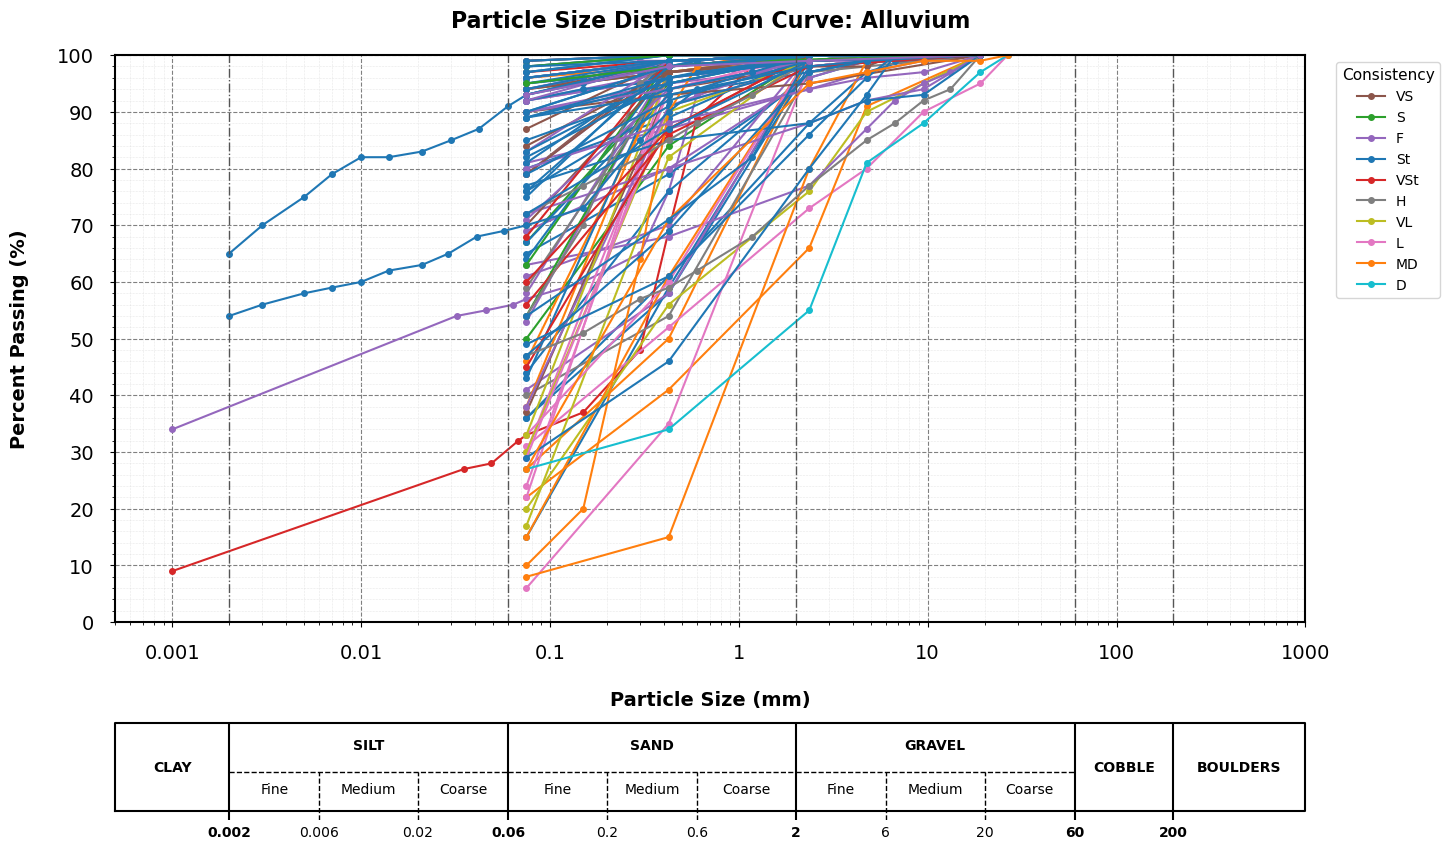

In [55]:
plot_psd(df=ALLUVIUM_PSD, color_by='Consistency', 
         title_suffix='Alluvium', 
         xmin=0.0005, 
         output_filepath=f"{output_folder}/PSD - Alluvium.png")

#### 3.1.2 Residual Soils & Extremely Weathered Rock

PSD analysis of weathered rock materials for excavation and slope stability assessment.

In [57]:
RS_XW_PSD = PSD_long_format.groupby('Geology_Orgin').get_group('RS_XW')
RS_XW_PSD['Consistency'].value_counts()

Consistency
St     140
H       69
VD      46
D       23
F       23
MD      15
VSt      9
L        6
Name: count, dtype: int64

Figure saved to: Output/2025626_1h/PSD - Residual Soils and Extremely Weathered Rocks.png


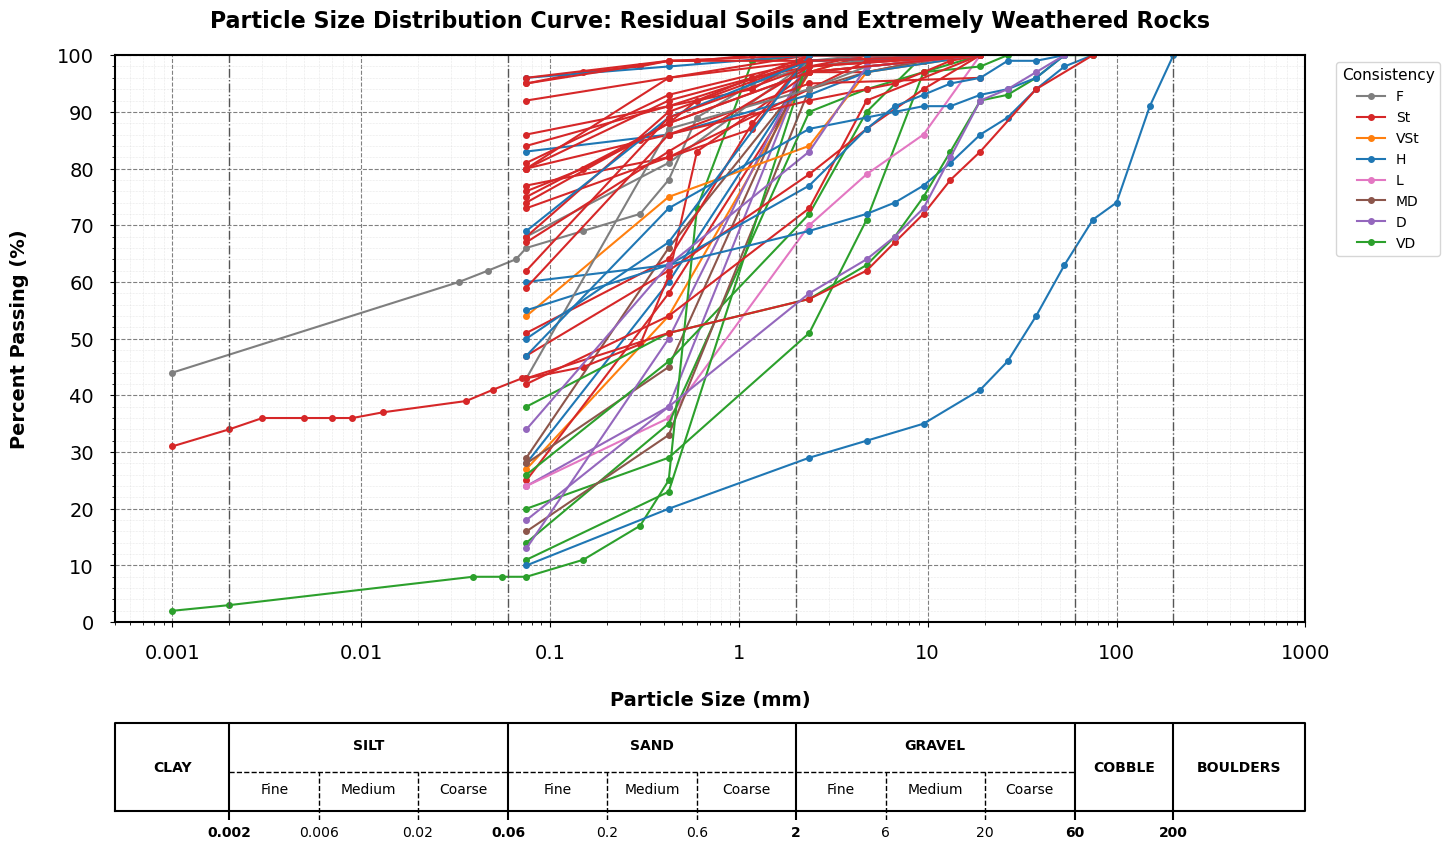

In [58]:
plot_psd(RS_XW_PSD, 
         color_by='Consistency', 
         xmin=0.0005, 
         title_suffix='Residual Soils and Extremely Weathered Rocks', 
         show_legend=True, 
         output_filepath=f"{output_folder}/PSD - Residual Soils and Extremely Weathered Rocks.png")

#### 3.1.3 Material Classification by Consistency

PSD analysis grouped by soil consistency classes for engineering property correlation.

Figure saved to: Output/2025626_1h/PSD -F.png


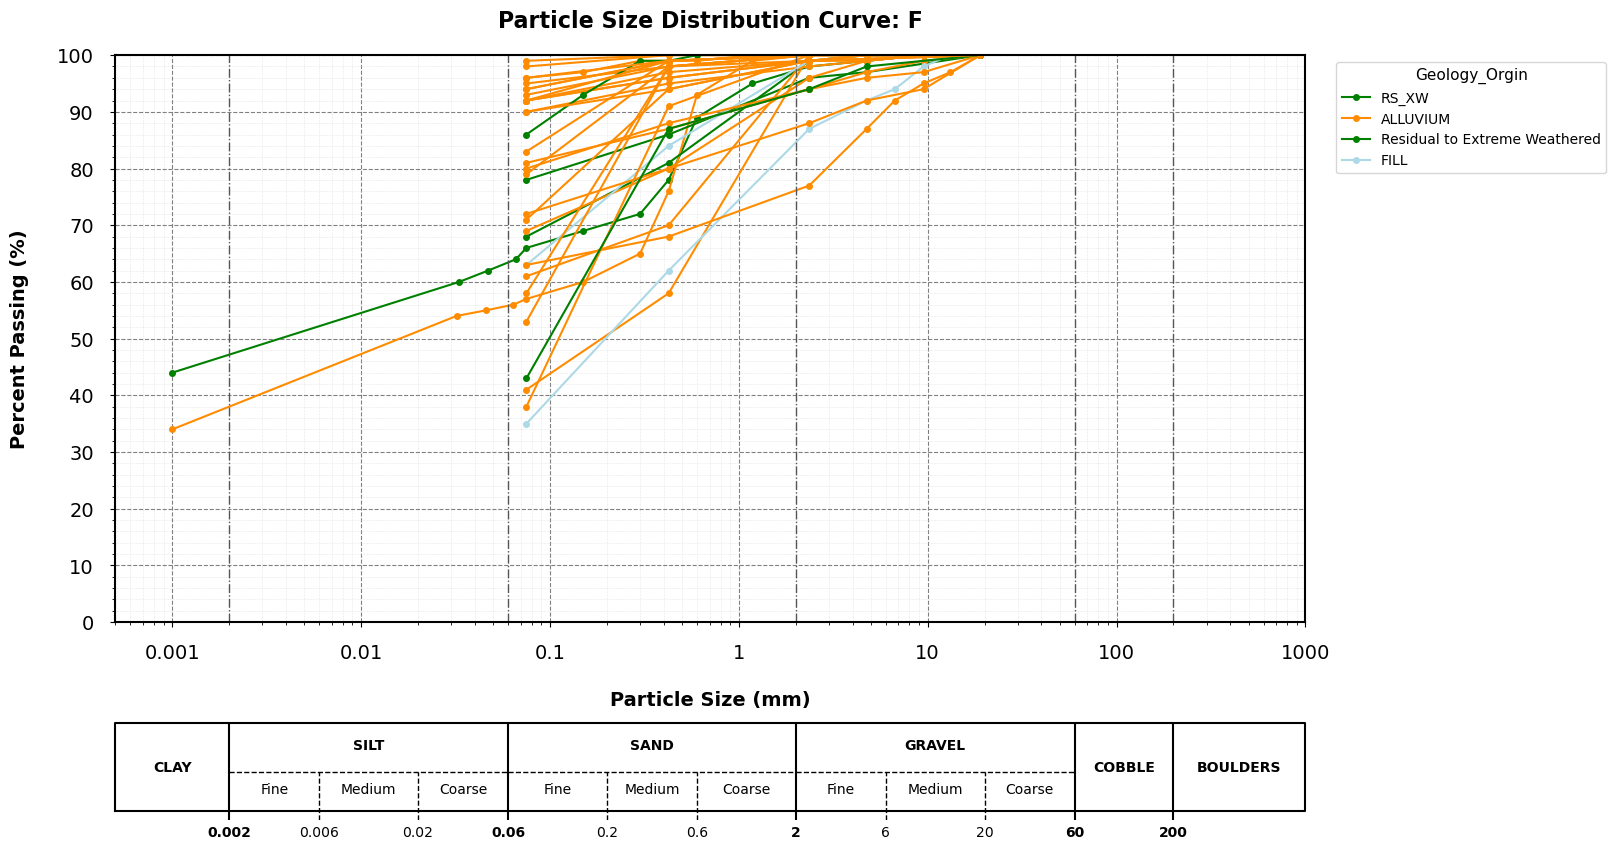

In [60]:
F_PSD = PSD_long_format.groupby('Consistency').get_group('F')
plot_psd(F_PSD, 
         color_by='Geology_Orgin', 
         xmin=0.0005, 
         title_suffix='F', 
         show_legend=True, 
         output_filepath=f"{output_folder}/PSD -F.png")

Figure saved to: Output/2025626_1h/PSD -VS.png


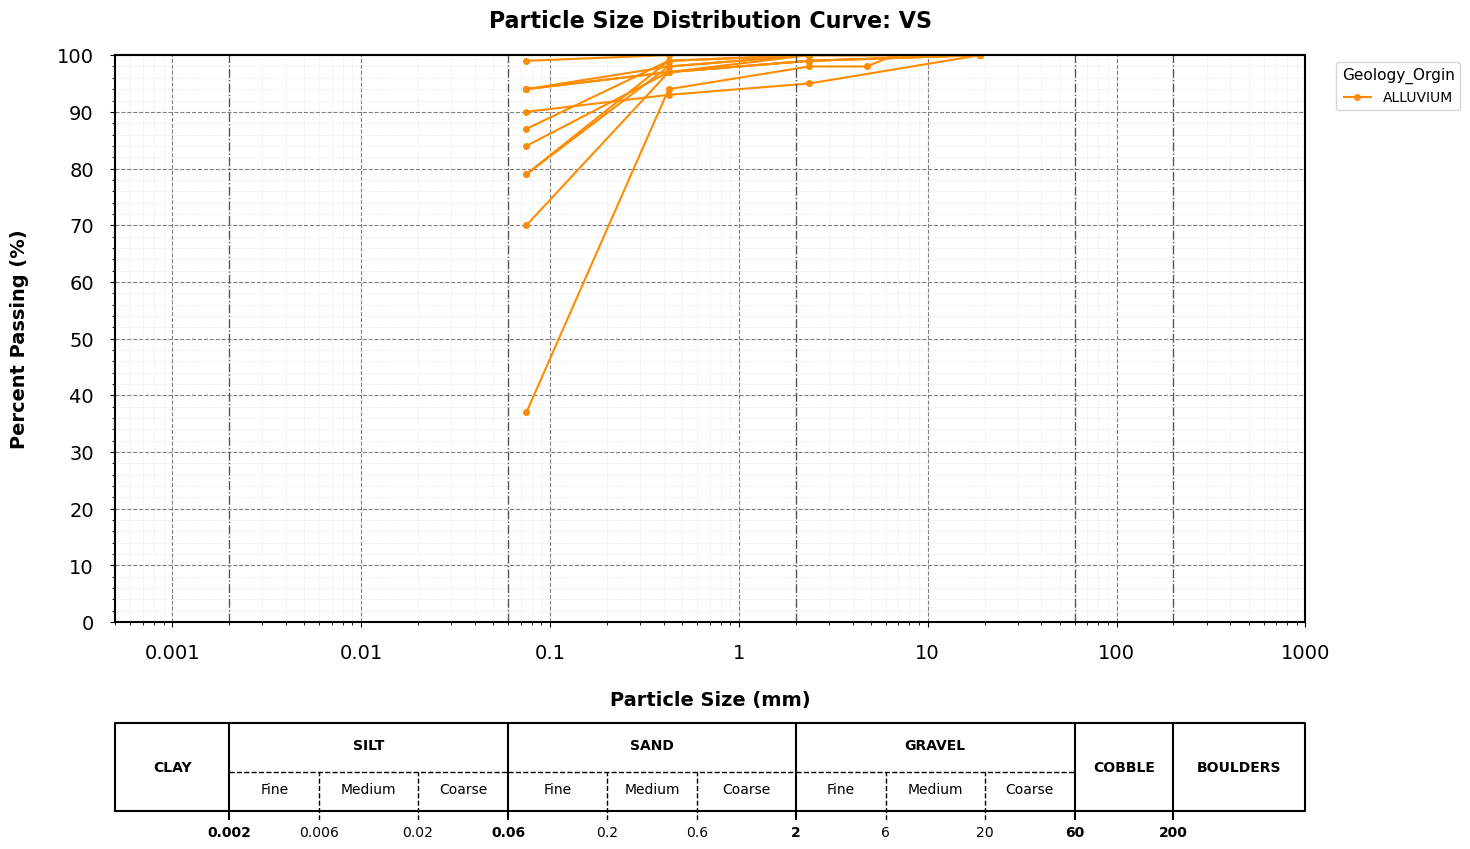

In [61]:
VS_PSD = PSD_long_format.groupby('Consistency').get_group('VS')
plot_psd(VS_PSD, 
         color_by='Geology_Orgin', 
         xmin=0.0005, 
         title_suffix='VS', 
         show_legend=True, 
         output_filepath=f"{output_folder}/PSD -VS.png")

Figure saved to: Output/2025626_1h/PSD -S.png


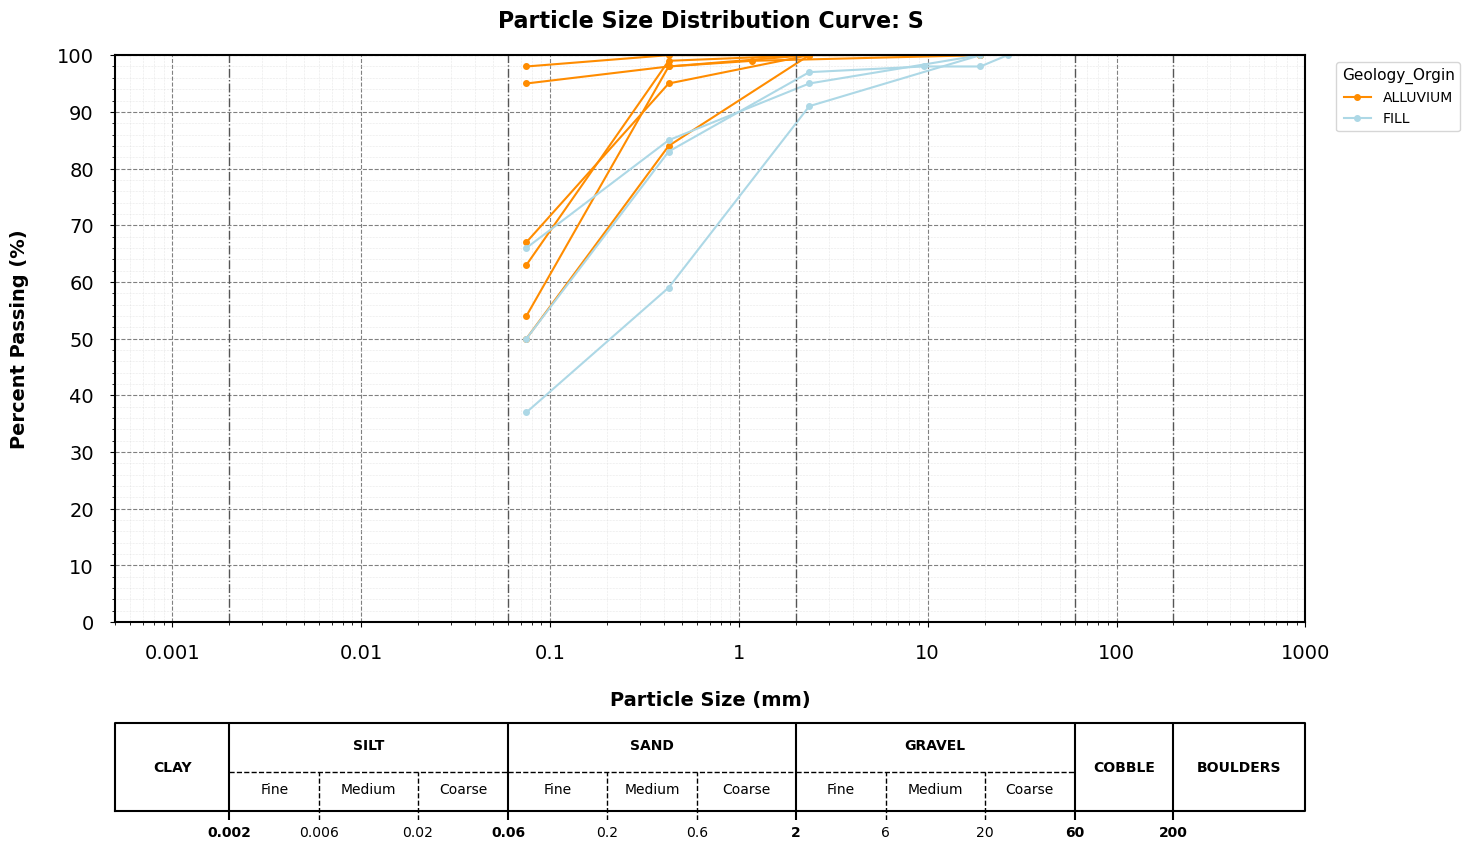

In [62]:
S_PSD = PSD_long_format.groupby('Consistency').get_group('S')
plot_psd(S_PSD, 
         color_by='Geology_Orgin', 
         xmin=0.0005, 
         title_suffix='S', 
         show_legend=True, 
         output_filepath=f"{output_folder}/PSD -S.png")

Figure saved to: Output/2025626_1h/PSD -St.png


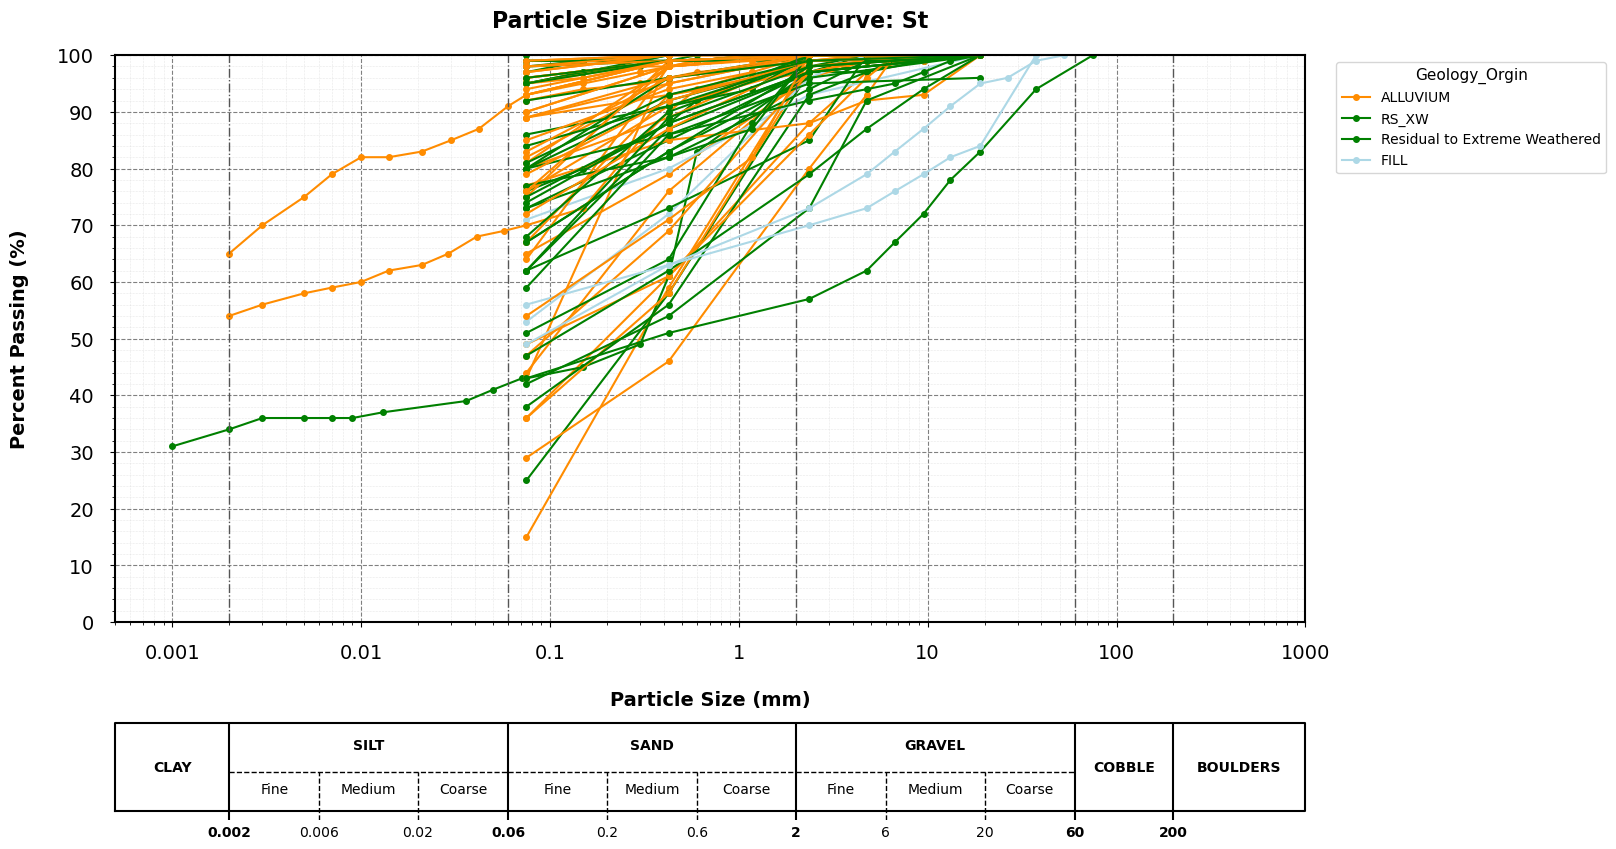

In [63]:
St_PSD = PSD_long_format.groupby('Consistency').get_group('St')
plot_psd(St_PSD, 
         color_by='Geology_Orgin', 
         xmin=0.0005, 
         title_suffix='St', 
         show_legend=True, 
         output_filepath=f"{output_folder}/PSD -St.png")

Figure saved to: Output/2025626_1h/PSD -VSt.png


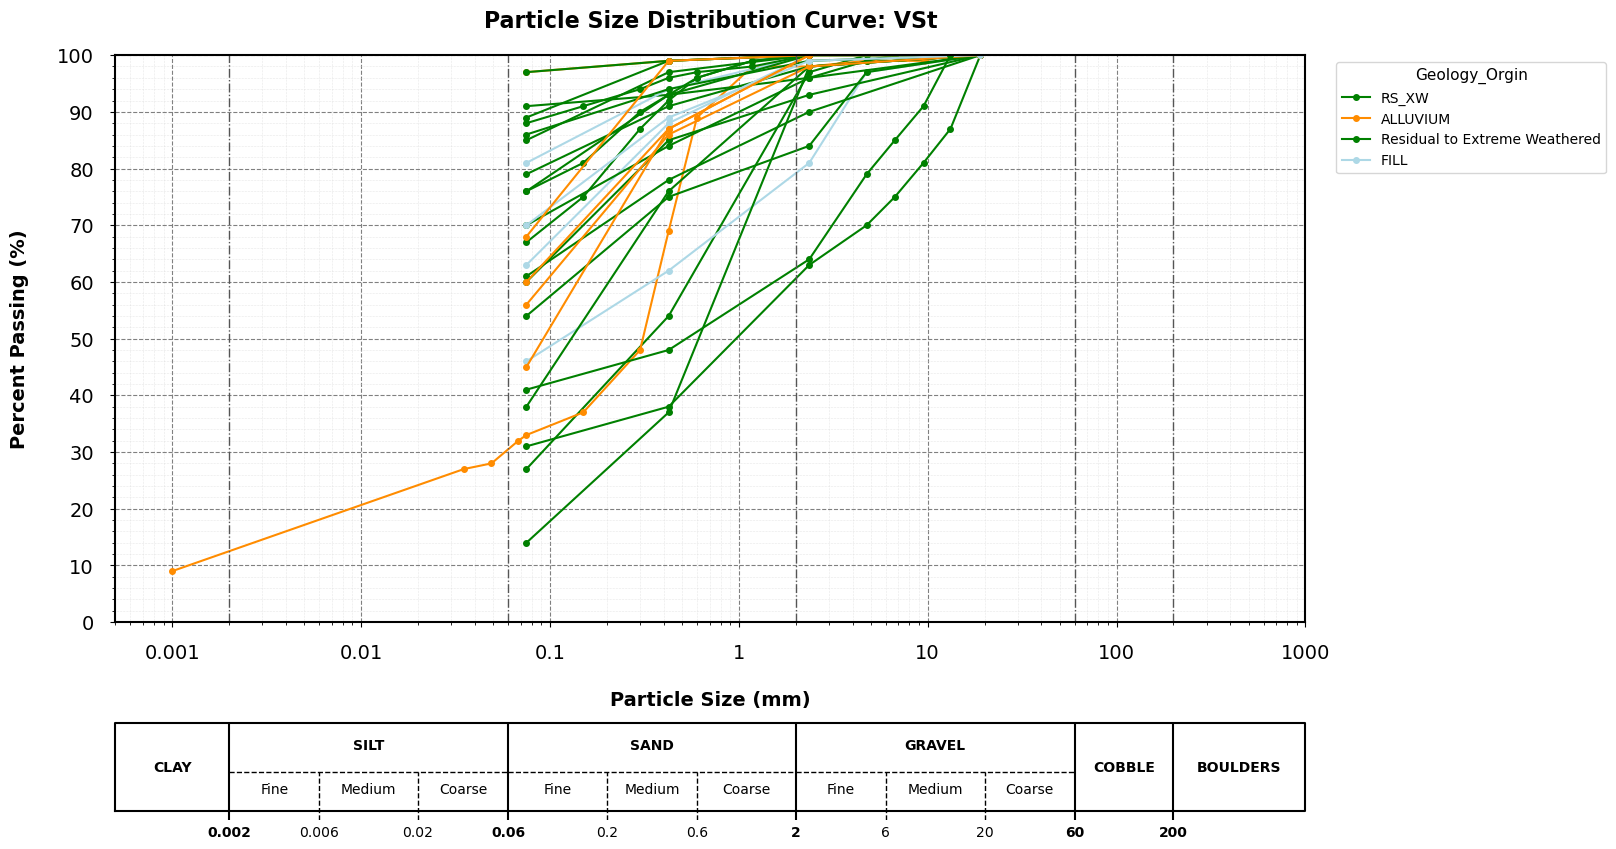

In [64]:
VSt_PSD = PSD_long_format.groupby('Consistency').get_group('VSt')
plot_psd(VSt_PSD, 
         color_by='Geology_Orgin', 
         xmin=0.0005, 
         title_suffix='VSt', 
         show_legend=True, 
         output_filepath=f"{output_folder}/PSD -VSt.png")

Figure saved to: Output/2025626_1h/PSD -H.png


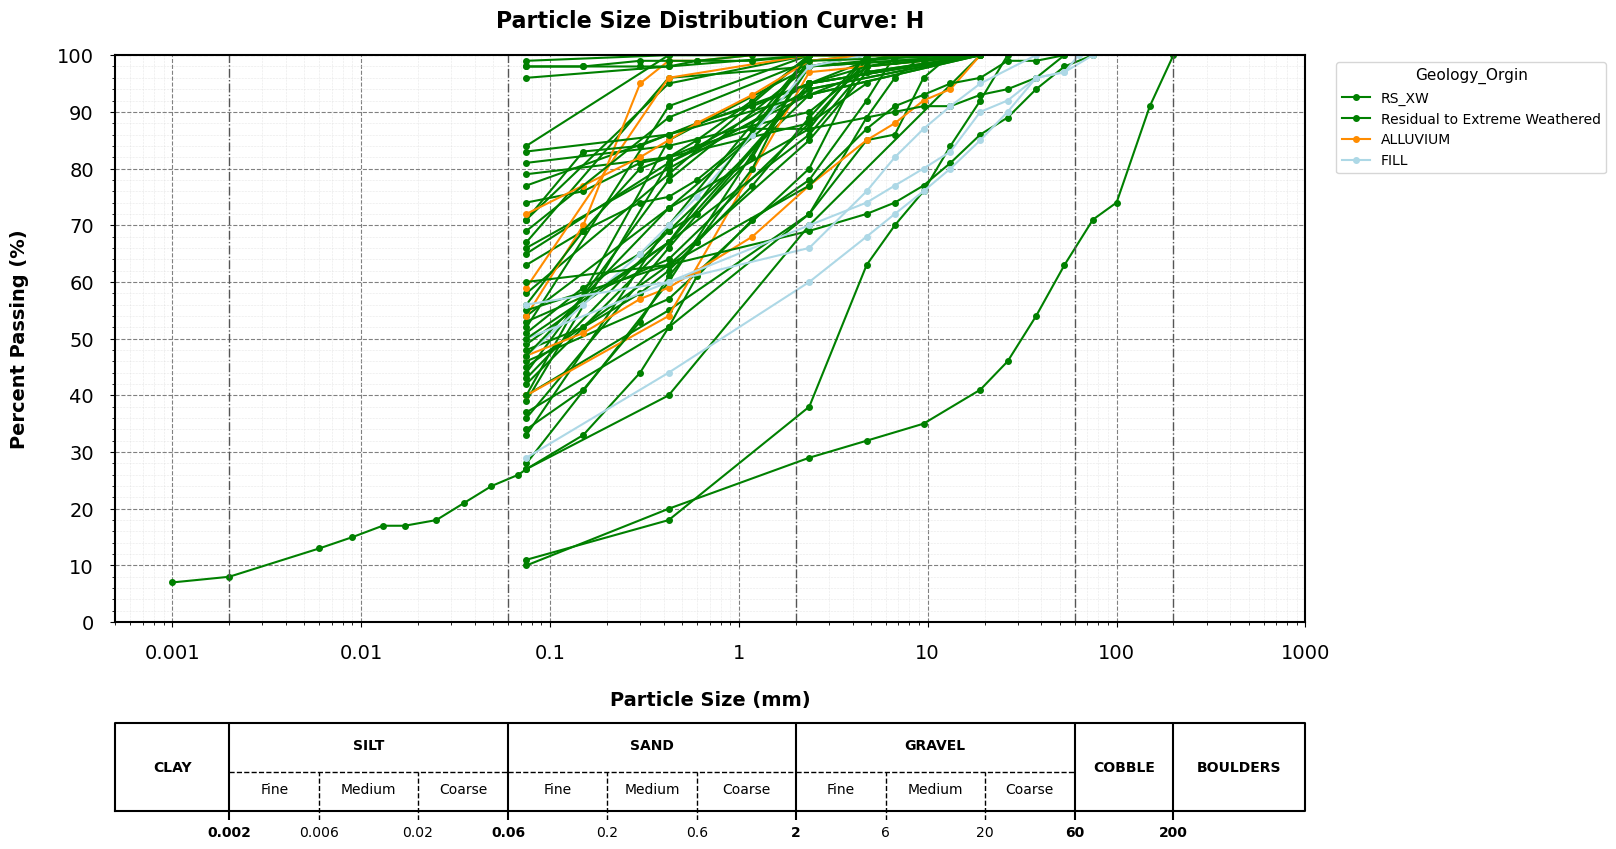

In [65]:
H_PSD = PSD_long_format.groupby('Consistency').get_group('H')
plot_psd(H_PSD, 
         color_by='Geology_Orgin', 
         xmin=0.0005, 
         title_suffix='H', 
         show_legend=True, 
         output_filepath=f"{output_folder}/PSD -H.png")

Figure saved to: Output/2025626_1h/PSD -VL.png


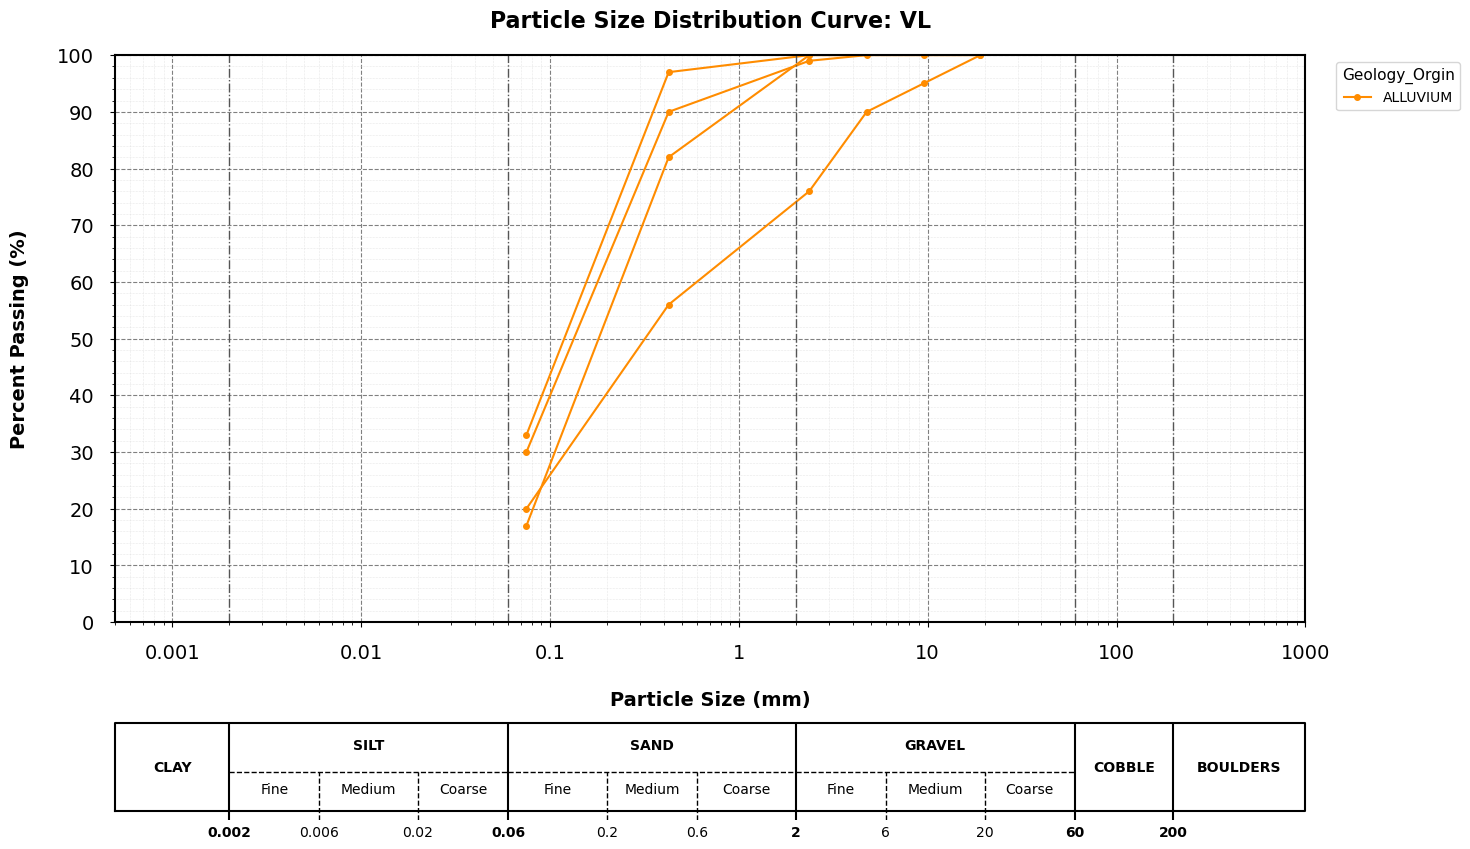

In [66]:
VL_PSD = PSD_long_format.groupby('Consistency').get_group('VL')
plot_psd(VL_PSD, 
         color_by='Geology_Orgin', 
         xmin=0.0005, 
         title_suffix='VL', 
         show_legend=True, 
         output_filepath=f"{output_folder}/PSD -VL.png")

Figure saved to: Output/2025626_1h/PSD -L.png


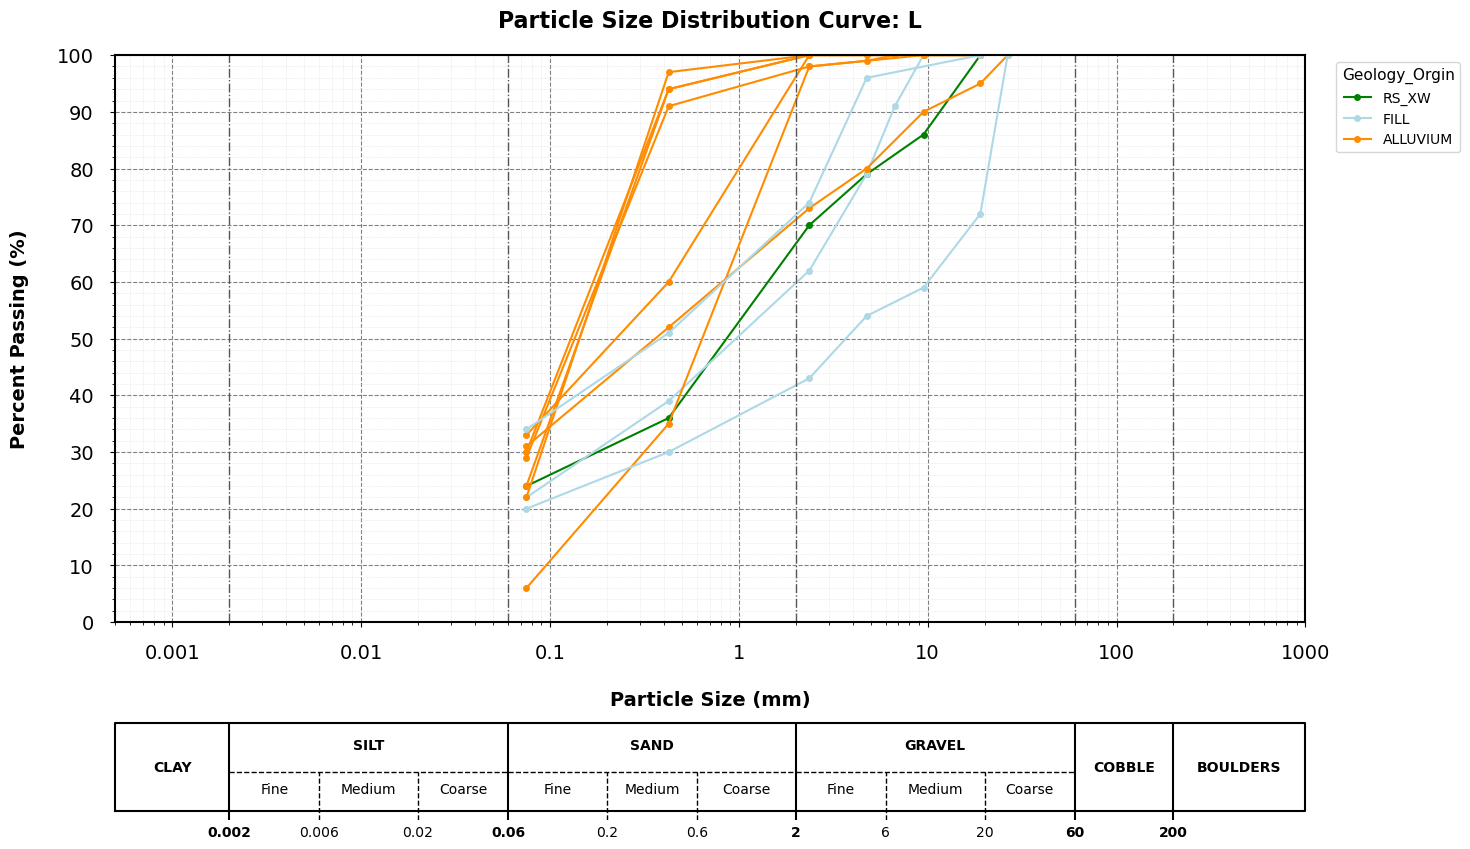

In [67]:
L_PSD = PSD_long_format.groupby('Consistency').get_group('L')
plot_psd(L_PSD, 
         color_by='Geology_Orgin', 
         xmin=0.0005, 
         title_suffix='L', 
         show_legend=True, 
         output_filepath=f"{output_folder}/PSD -L.png")

Figure saved to: Output/2025626_1h/PSD -MD.png


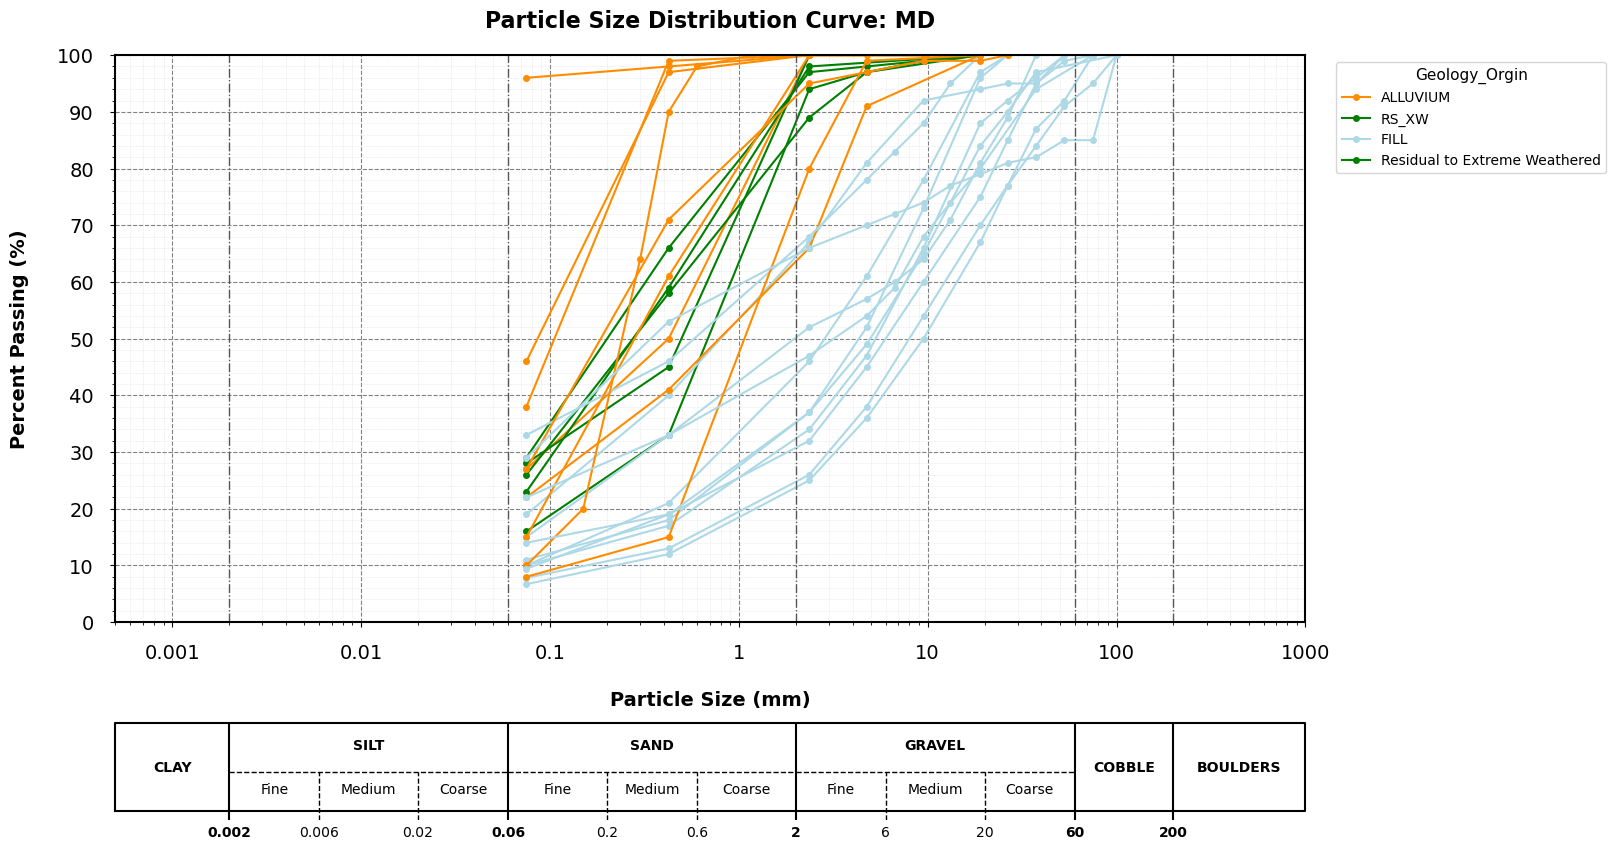

In [68]:
MD_PSD = PSD_long_format.groupby('Consistency').get_group('MD')
plot_psd(MD_PSD, 
         color_by='Geology_Orgin', 
         xmin=0.0005, 
         title_suffix='MD', 
         show_legend=True, 
         output_filepath=f"{output_folder}/PSD -MD.png")

Figure saved to: Output/2025626_1h/PSD -D.png


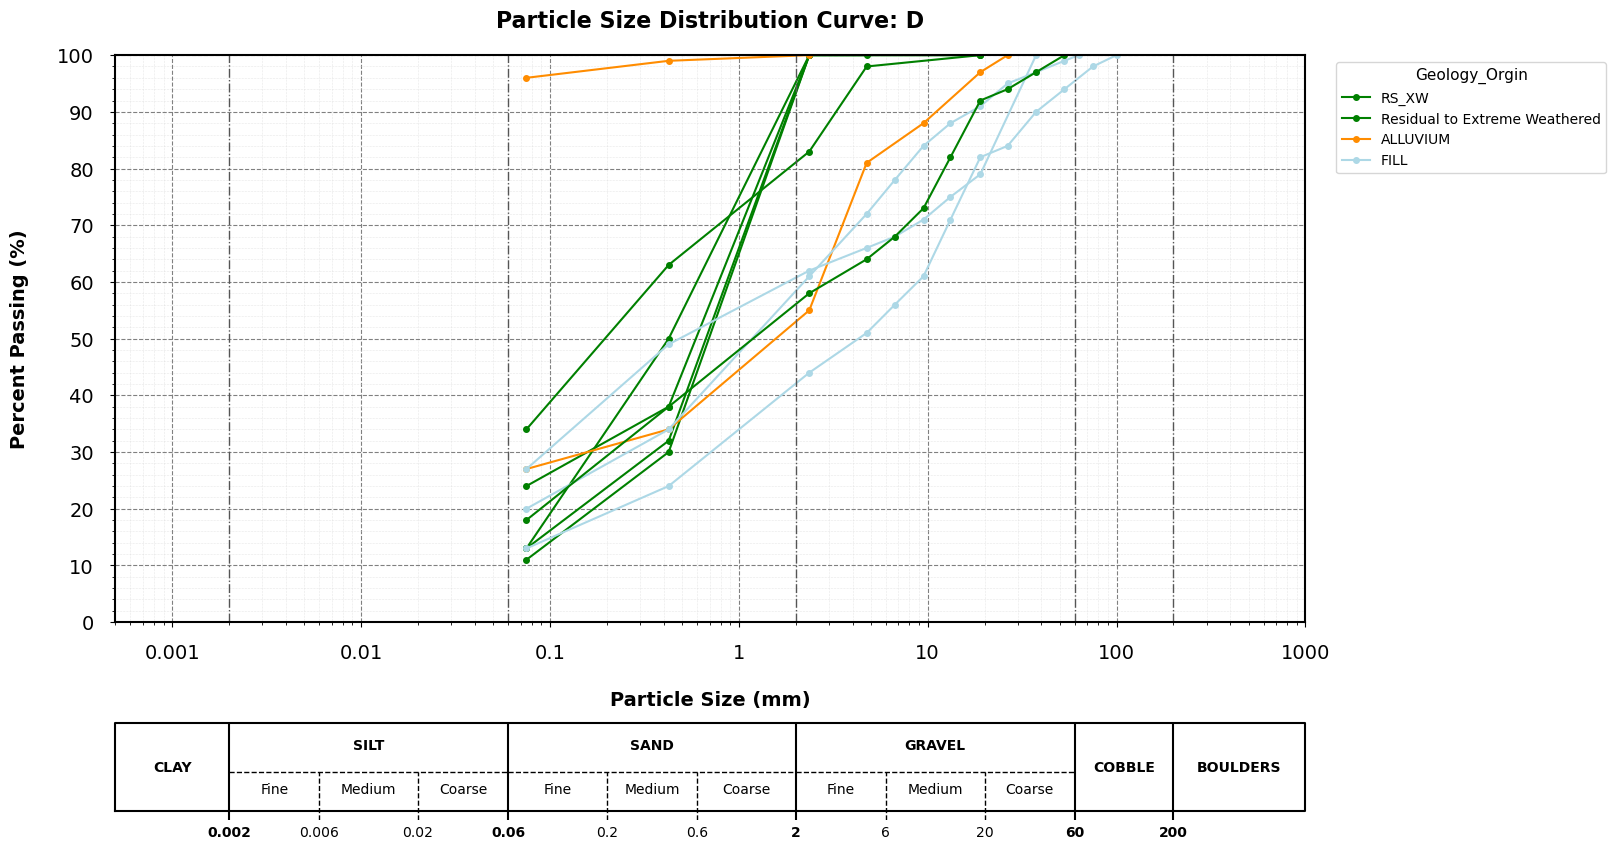

In [69]:
D_PSD = PSD_long_format.groupby('Consistency').get_group('D')
plot_psd(D_PSD, 
         color_by='Geology_Orgin', 
         xmin=0.0005, 
         title_suffix='D', 
         show_legend=True, 
         output_filepath=f"{output_folder}/PSD -D.png")

Figure saved to: Output/2025626_1h/PSD -VD.png


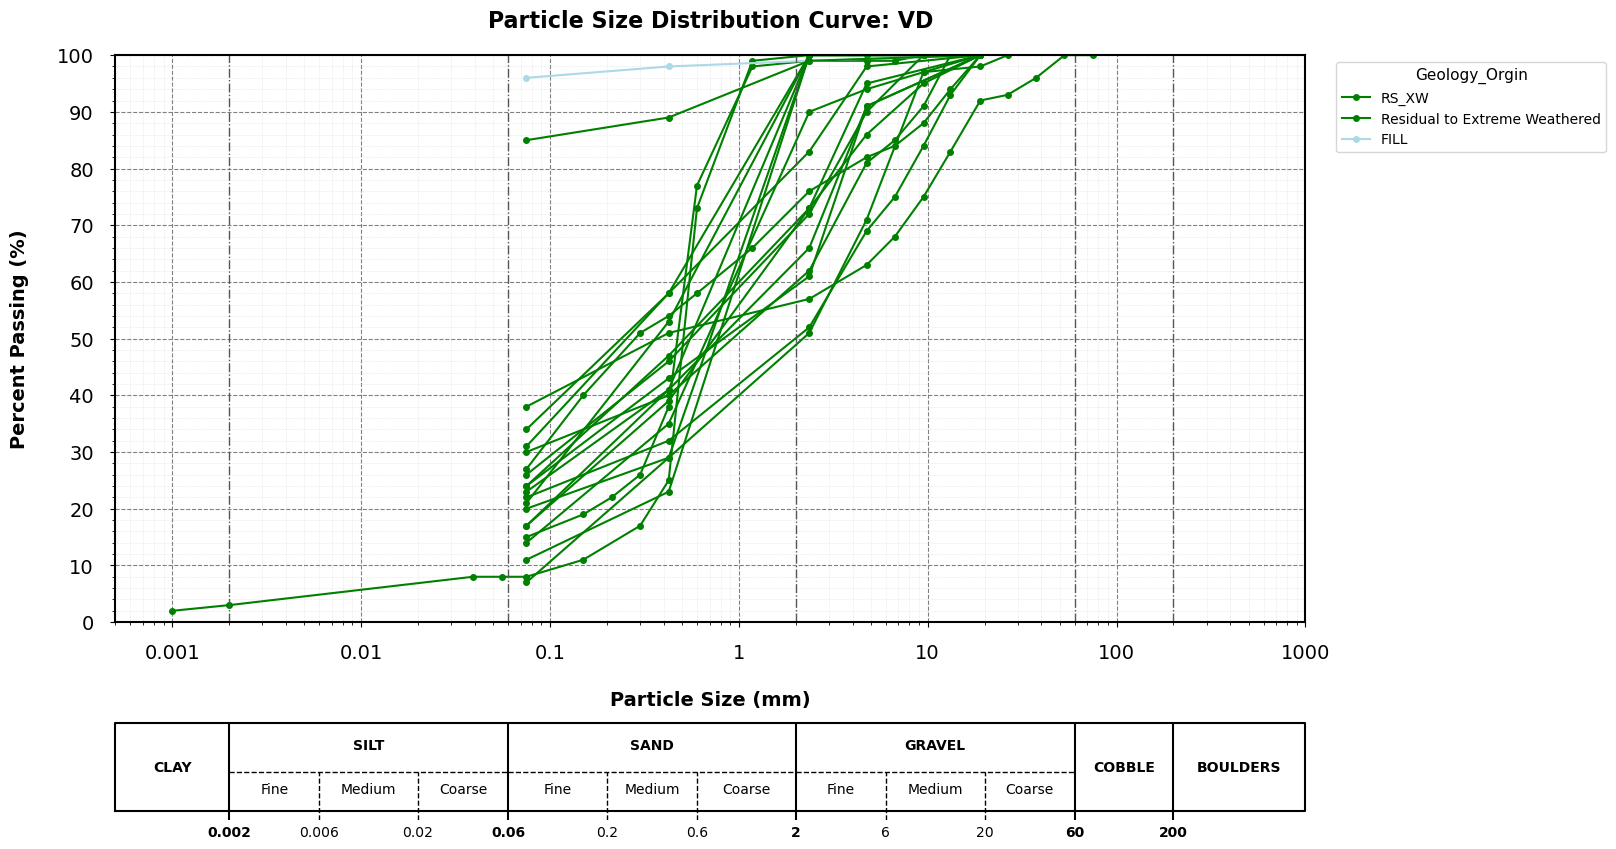

In [70]:
VD_PSD = PSD_long_format.groupby('Consistency').get_group('VD')
plot_psd(VD_PSD, 
         color_by='Geology_Orgin', 
         xmin=0.0005, 
         title_suffix='VD', 
         show_legend=True, 
         output_filepath=f"{output_folder}/PSD -VD.png")

### 3.2 Atterberg Limits Classification

Plasticity classification charts for soil behavior assessment and foundation design.

In [72]:
Atterberg_final.columns

Index(['Hole_ID', 'Type', 'From_mbgl', 'To_mbgl', 'Chainage',
       'Surface RL (m AHD)', 'BH Depth (m)', 'Geology_Orgin', 'Map_symbol',
       'Consistency', 'Report', 'Atterberg?', 'LL (%)', 'PL (%)', 'PI (%)',
       'LS (%)', 'MC (%) - from Atterberg test'],
      dtype='object')

In [73]:
Atterberg_final['Geology_Orgin'].value_counts()

Geology_Orgin
ALLUVIUM                         107
Residual to Extreme Weathered     71
RS_XW                             64
FILL                              34
TOPSOIL                            2
Dcf                                1
Name: count, dtype: int64

INFO: Data ranges - LL: 17.0 to 144.0, PI: 1.0 to 112.0
INFO: Plot ranges - X: 0 to 100.0, Y: 0 to 80.0
INFO: Applied specific default styles for ALLUVIAL/ALLUVIUM, RESIDUAL, FILL where applicable.
Plot saved successfully to: Output/2025626_1h/Atterberg - Alluvium.png


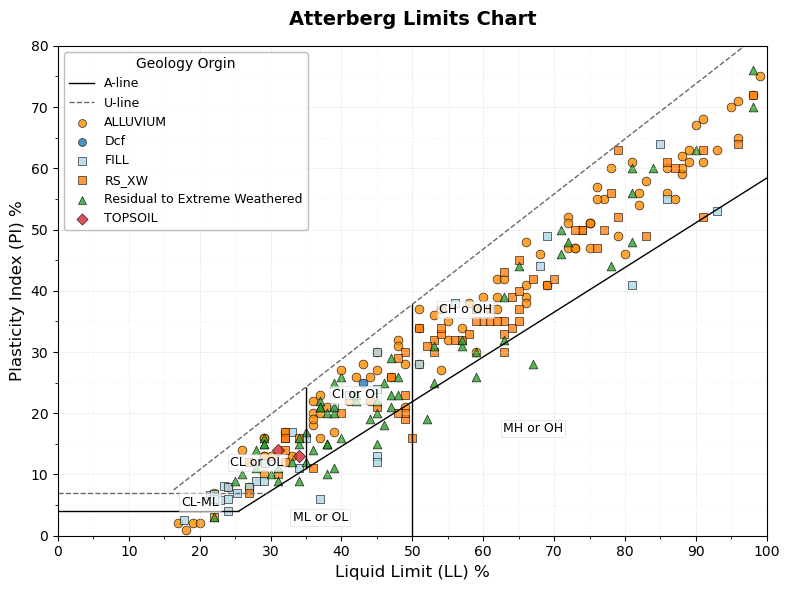

--- Plotting finished for Atterberg Limits (Geology_Orgin) ---



In [74]:
plot_atterberg_chart(Atterberg_final, ll_col='LL (%)', pi_col='PI (%)', category_col='Geology_Orgin', 
                    output_filepath=f"{output_folder}/Atterberg - Alluvium.png",
                    show_plot=True, figsize=(8,6))

#### 3.2.1 Alluvium Plasticity Characteristics

INFO: Data ranges - LL: 17.0 to 144.0, PI: 1.0 to 112.0
INFO: Plot ranges - X: 0 to 100.0, Y: 0 to 80.0
INFO: Applied specific default styles for ALLUVIAL/ALLUVIUM, RESIDUAL, FILL where applicable.
Plot saved successfully to: Output/2025626_1h/Atterberg - Alluvium.png


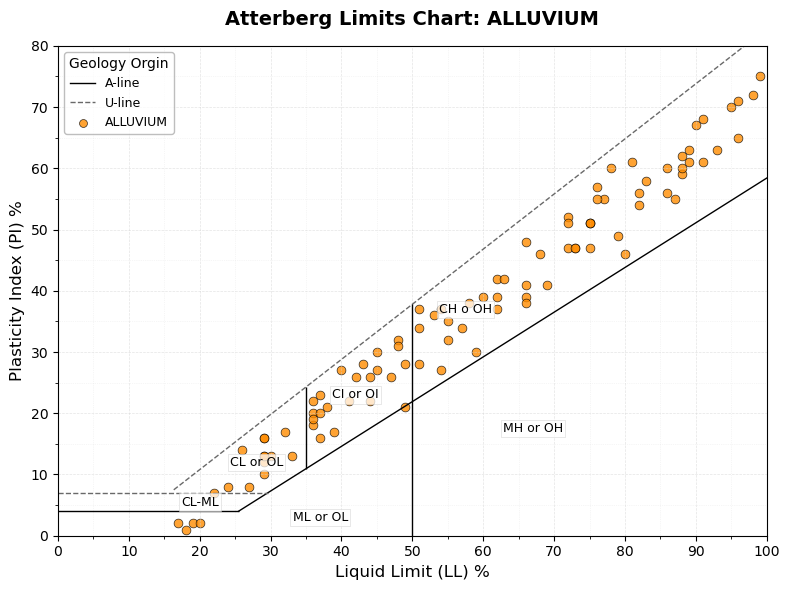

--- Plotting finished for Atterberg Limits (Geology_Orgin) ---



In [76]:
Alluvium_atterberg = Atterberg_final.groupby('Geology_Orgin').get_group('ALLUVIUM')

plot_atterberg_chart(Alluvium_atterberg, ll_col='LL (%)', pi_col='PI (%)', category_col='Geology_Orgin', 
                    title_suffix='ALLUVIUM', output_filepath=f"{output_folder}/Atterberg - Alluvium.png",
                    show_plot=True, figsize=(8,6))

#### 3.2.2 Residual Soils & Extremely Weathered Rock Plasticity

INFO: Data ranges - LL: 22.0 to 98.0, PI: 3.0 to 72.0
INFO: Plot ranges - X: 0 to 100.0, Y: 0 to 80.0
Plot saved successfully to: Output/2025626_1h/Atterberg - Residual Soils and Extremely Weathered Rocks.png


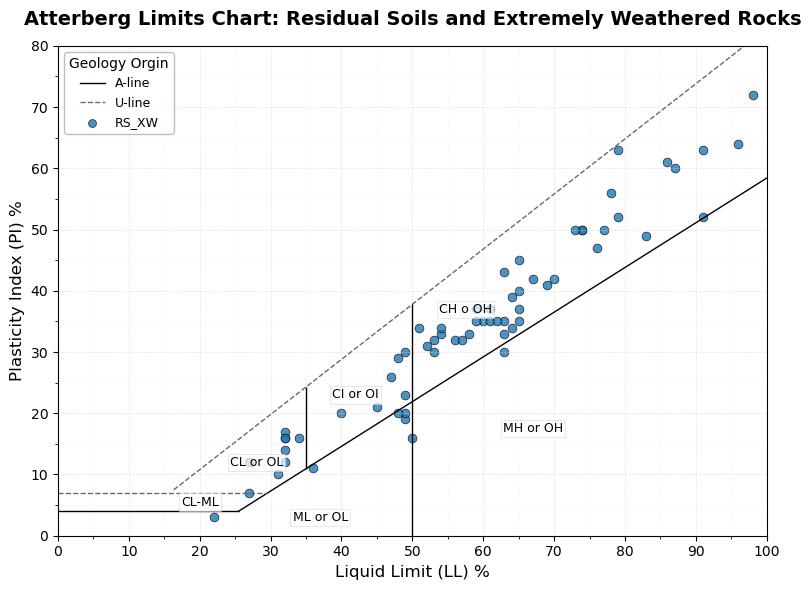

--- Plotting finished for Atterberg Limits (Geology_Orgin) ---



In [78]:
RS_XW_atterberg = Atterberg_final.groupby('Geology_Orgin').get_group('RS_XW')

plot_atterberg_chart(RS_XW_atterberg, ll_col='LL (%)', pi_col='PI (%)', category_col='Geology_Orgin', 
                  title_suffix='Residual Soils and Extremely Weathered Rocks', 
                     output_filepath=f"{output_folder}/Atterberg - Residual Soils and Extremely Weathered Rocks.png",
                    show_plot=True)

### 3.3 Emerson Class Analysis

Dispersion testing results for earthworks construction and erosion potential assessment.

In [80]:
Emerson_final.head()
Emerson_final = Emerson_final.rename(columns={'Emerson' : 'Emerson class'})
Emerson_final.head(3)

Hole_ID Type  From_mbgl  To_mbgl  Chainage Surface RL (m AHD)  \
0    ARU-K-AH05   AH        1.0     1.45   21200.0              49.04   
173       BH-01   BH        1.0     1.09   23610.0              40.24   
211       BH-05   BH        1.0     1.45   24520.0                 54   

     BH Depth (m)                  Geology_Orgin Map_symbol Consistency  \
0             NaN                       ALLUVIUM       Toce          St   
173         10.00                           FILL      Qha/1           F   
211         25.05  Residual to Extreme Weathered       RJbw           H   

                    Report Emerson?  Emerson class  
0          ARUP Kuraby GFR        Y            2.0  
173  DTMR GFR_FG23024-R4.2        Y            5.0  
211  DTMR GFR_FG23024-R4.2        Y            5.0


--- Generating Plot for: Geology_Orgin ---
Plot saved successfully to: Output/2025626_1h/Emerson - Project Wide.png


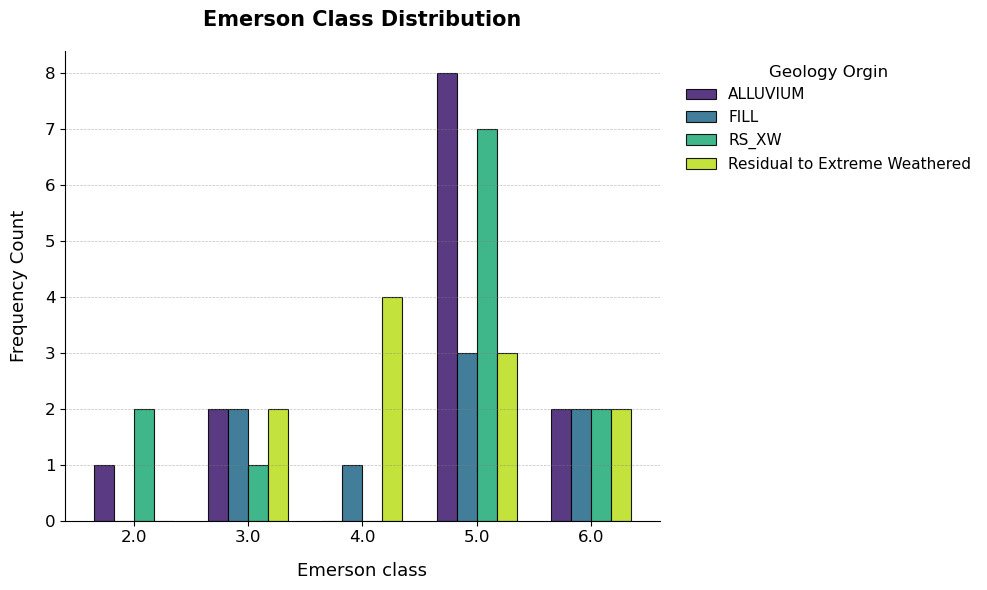

--- Plotting finished for: Geology_Orgin ---



In [81]:
plot_emerson_by_origin(Emerson_final, origin_col='Geology_Orgin', 
                       output_filepath=f"{output_folder}/Emerson - Project Wide.png")

Plot saved to: Output/2025626_1h/Emerson_by_chainage.png


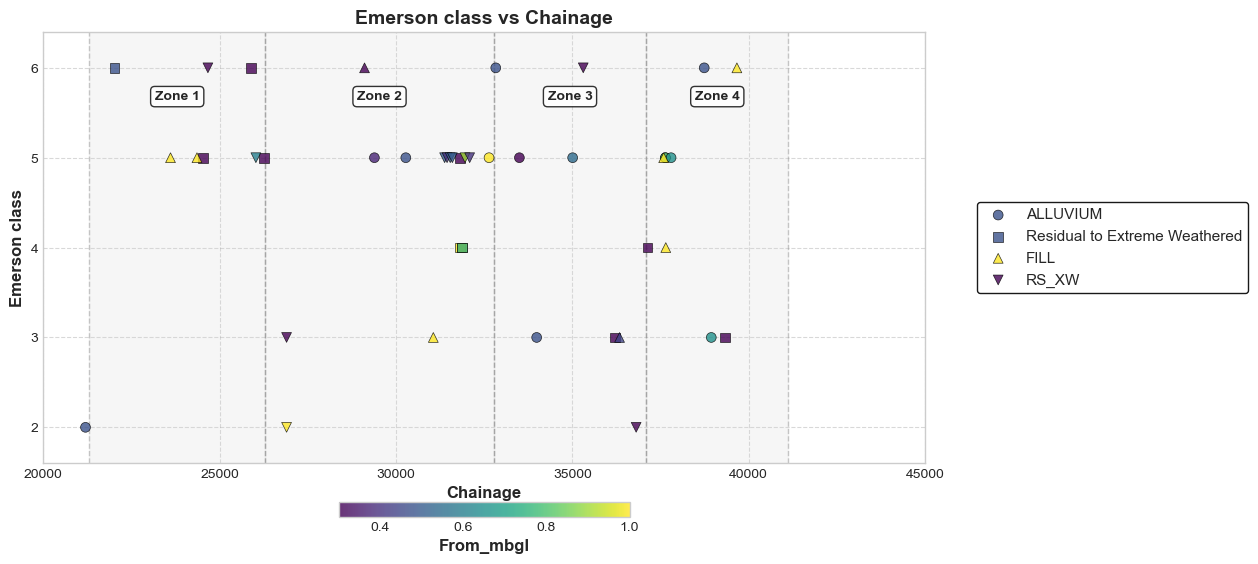

--- Property vs Chainage plotting finished ---


In [82]:
Zonage = {"Zone 1": (21300, 26300),
          "Zone 2": (26300, 32770),
          "Zone 3": (32770, 37100),
          "Zone 4": (37100, 41120)}

plot_by_chainage(Emerson_final, chainage_col='Chainage', 
                 property_col='Emerson class', 
                 category_by_col='Geology_Orgin',
                 color_by_col='From_mbgl',legend_outside=True,
                 figsize=(13,6),
                 xlim = (20000, 45000),
                 classification_zones=Zonage, 
                 zone_orientation='vertical',
                 show_zone_boundaries=True, 
                 show_zone_labels=True, 
                 output_filepath=f"{output_folder}/Emerson_by_chainage.png"
                )

### 3.4 Standard Penetration Test (SPT) Analysis

In-situ strength and density assessment for foundation design and bearing capacity evaluation.

#### 3.4.1 Cohesive Materials

SPT N-values for cohesive soils with undrained shear strength correlations.

Plot saved to: Output/2025626_1h/SPT - Cohesive.png


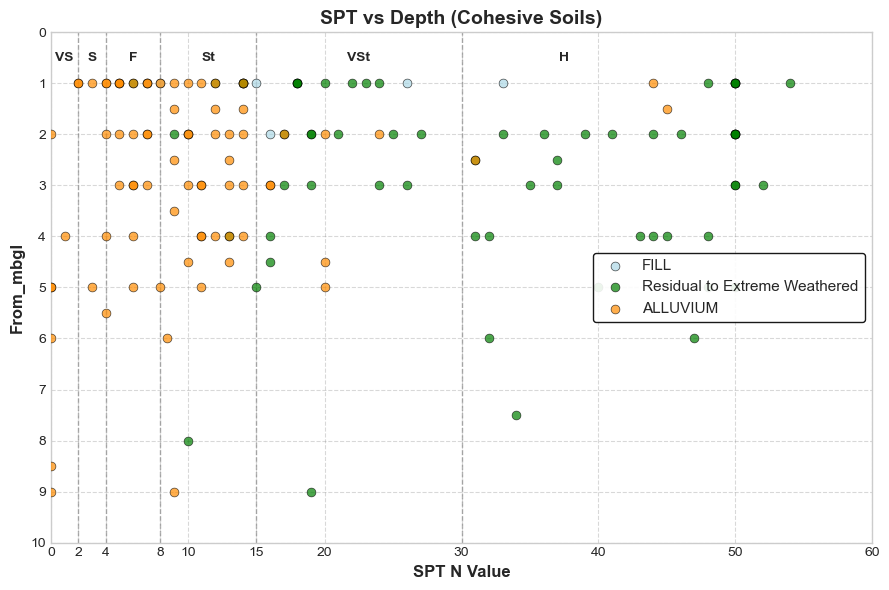

--- SPT vs Depth (Cohesive) plotting finished ---


In [117]:
SPT_cohesive = SPT[SPT['Material Type']=='Cohesive']

plot_SPT_vs_depth_cohesive(SPT_cohesive, 
                           depth_col='From_mbgl', 
                           category_col='Geology_Orgin', 
                           spt_col='SPT N Value', 
                           strength_indicator_position=0.95, legend_loc='right',
                           xlim=(0,51), 
                           ylim=(0,10), 
                           ytick_interval=1, 
                           xtick_interval=10,
                           output_filepath=f"{output_folder}/SPT - Cohesive.png"
                          )

#### 3.4.2 Granular Materials

SPT N-values for granular soils with relative density and friction angle correlations.

Plot saved to: Output/2025626_1h/SPT - Granular.png


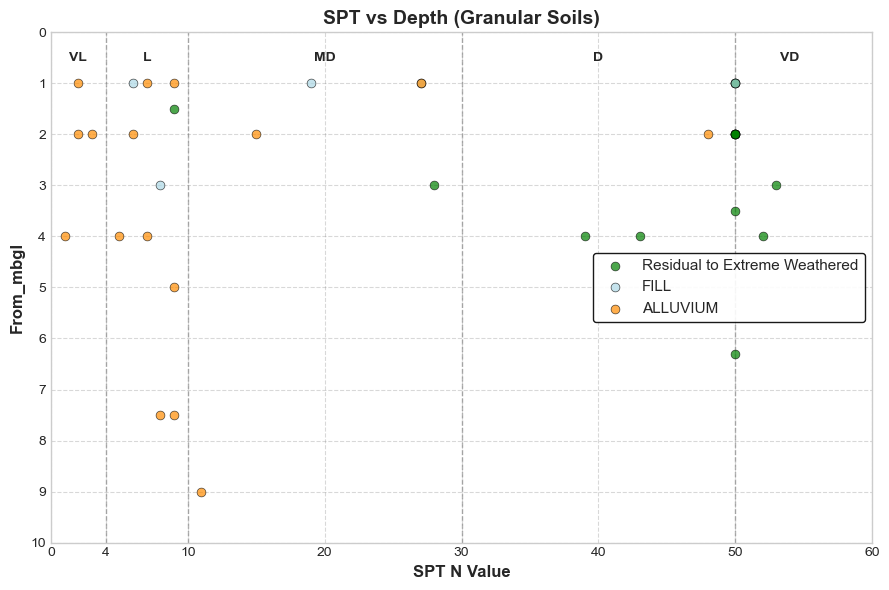

--- SPT vs Depth (Granular) plotting finished ---


In [121]:
SPT_granular = SPT[SPT['Material Type']=='Granular']

plot_SPT_vs_depth_granular(SPT_granular, 
                           depth_col='From_mbgl', 
                           category_col='Geology_Orgin', 
                           spt_col='SPT N Value', 
                           strength_indicator_position=0.95,legend_loc='right',
                           xlim=(0,51), 
                           ylim=(0,10), 
                           ytick_interval=1, 
                           xtick_interval=10,
                           output_filepath=f"{output_folder}/SPT - Granular.png"
                          )

### 3.5 Moisture Content Plots

In [123]:
Moisture_Cont.head()

Hole_ID Type  From_mbgl  To_mbgl  Chainage Surface RL (m AHD)  \
3   ARU-K-AH06   AH        2.7      NaN   21200.0              49.44   
5   ARU-K-AH17   AH        1.2      NaN   22000.0              54.99   
11  ARU-K-AH21   AH        1.2      NaN   22200.0              45.85   
14  ARU-K-AH22   AH        1.2      NaN   22100.0              52.79   
17  ARU-K-AH24   AH        4.2      NaN   22200.0              46.32   

    BH Depth (m) Geology_Orgin Map_symbol Consistency           Report  MC_%  \
3            NaN         RS_XW       Toce           H  ARUP Kuraby GFR  18.6   
5            NaN         RS_XW       RJbw         VSt  ARUP Kuraby GFR   9.6   
11           NaN      ALLUVIUM        Tos          St  ARUP Kuraby GFR  23.8   
14           NaN         RS_XW        Tos          St  ARUP Kuraby GFR  18.2   
17           NaN         RS_XW        Tos         VSt  ARUP Kuraby GFR  16.3   

    MC (%) - from Atterberg test  MC before Swell Test (%)  \
3                           18.6                       NaN   
5                            9.6                       NaN   
11                          23.8                       NaN   
14                          18.2                       NaN   
17                          16.3                       NaN   

    MC (%) - from CBR test  Initial MC (%) MC(%) from Durability Test  
3                      NaN             NaN                        NaN  
5                      NaN             NaN                        NaN  
11                     NaN             NaN                        NaN  
14                     NaN             NaN                        NaN  
17                     NaN             NaN                        NaN

#### 3.51 Moisture content vs depth

Plot saved to: Output/2025626_1h/Moisture content vs Depth.png


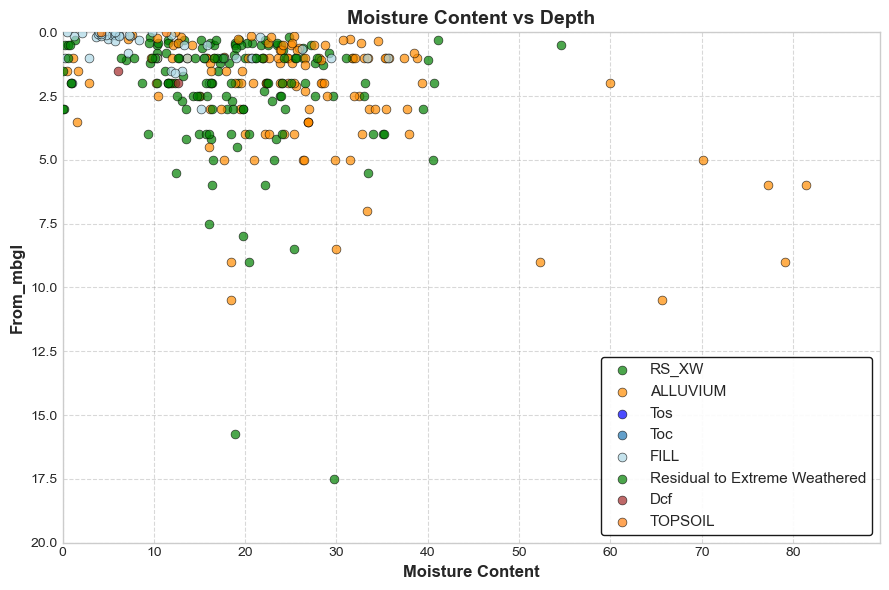

--- Engineering Property vs Depth plotting finished ---


In [125]:
plot_engineering_property_vs_depth(Moisture_Cont, 
                                   property_col='MC_%', 
                                   ylim = (0,20),
                                   category_col = 'Geology_Orgin',
                                   ytick_interval = 2.5,
                                   title="Moisture Content vs Depth", 
                                   property_name="Moisture Content", 
                                   output_filepath=f"{output_folder}/Moisture content vs Depth.png")

#### 3.52 Moisture content vs chainage

Plot saved to: Output/2025626_1h/Moisture_content_by_chainage.png


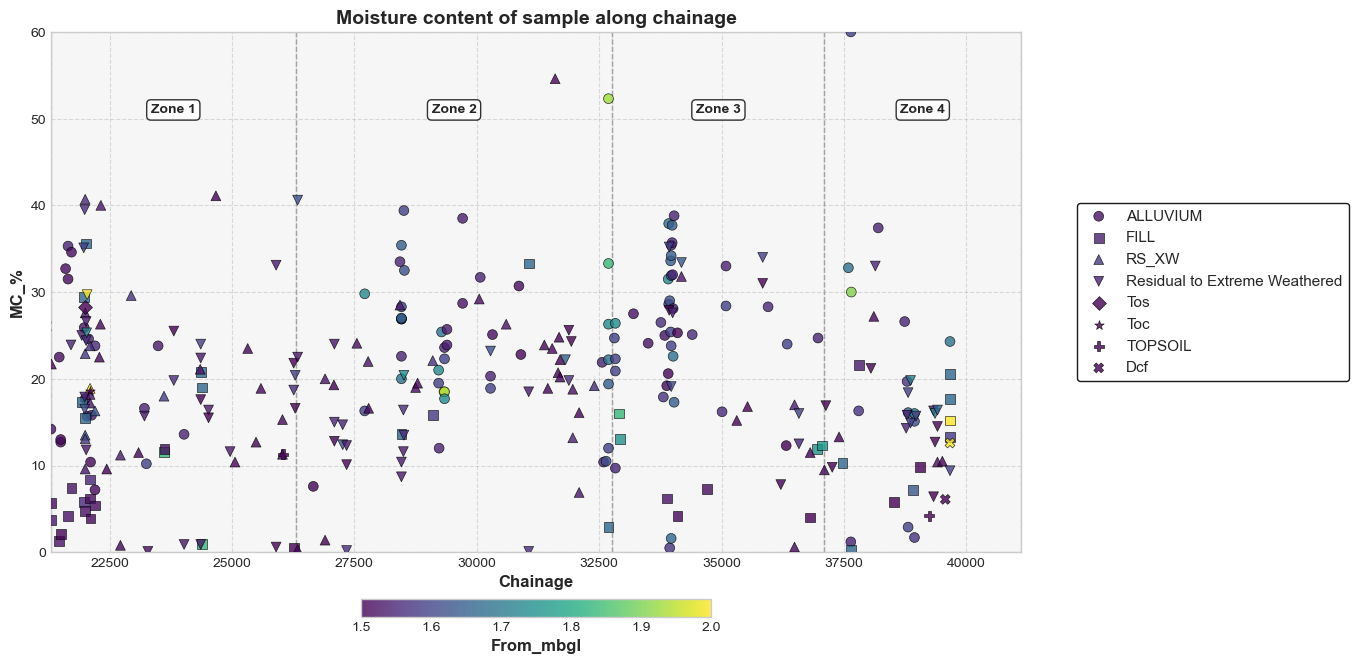

--- Property vs Chainage plotting finished ---


In [127]:
Zonage = {"Zone 1": (21300, 26300),
          "Zone 2": (26300, 32770),
          "Zone 3": (32770, 37100),
          "Zone 4": (37100, 41120)}

plot_by_chainage(Moisture_Cont, chainage_col='Chainage', property_col='MC_%', 
                 figsize=(14,7),
                 xlim = (21300, 41120), ylim=(0,60),
                 title="Moisture content of sample along chainage",
                 classification_zones=Zonage, 
                 category_by_col='Geology_Orgin',
                 color_by_col = 'From_mbgl', 
                 zone_orientation='vertical',
                 show_zone_boundaries=True, 
                 legend_outside=True,
                 legend_position='right',
                 show_zone_labels=True, 
                 output_filepath=f"{output_folder}/Moisture_content_by_chainage.png"
                )

### 3.6 Distribution by thickness plots

In [129]:
BH_Interpretation.pivot_table(values='Thickness', index=['Geology_Orgin',"Consistency"], aggfunc='sum')
BH_Interpretation['Geology_Orgin'].unique()

array(['TOPSOIL', 'RS_XW', 'Dcf', 'ALLUVIUM', 'FILL', 'Rjbw', 'Rin',
       'Tos', 'Toc', nan, 38.45, 'ASPHALT'], dtype=object)

In [130]:
Tos_BH_interp = BH_Interpretation.groupby('Geology_Orgin').get_group('Tos')
Dcf_BH_interp = BH_Interpretation.groupby('Geology_Orgin').get_group('Dcf')
Rjbw_BH_interp = BH_Interpretation.groupby('Geology_Orgin').get_group('Rjbw')
Rin_BH_interp = BH_Interpretation.groupby('Geology_Orgin').get_group('Rin')
Tos_BH_interp['Consistency'].unique()

array(['5b', '5a', '4b', '3a', '2b', '4a', '3b', '2a'], dtype=object)

#### 3.61 Distribution of Rock Class by Thickness of Sunnybank Formation (Tos)

In [132]:
Tos = Tos_BH_interp.pivot_table(values='Thickness', index="Consistency", aggfunc='sum').reset_index()
Tos.insert(loc=2, column='thickness_proportion_%', value=(Tos['Thickness']/Tos['Thickness'].sum())*100)
Tos

Consistency  Thickness  thickness_proportion_%
0          2a       0.60                0.301826
1          2b       1.37                0.689169
2          3a      16.99                8.546708
3          3b       9.18                4.617939
4          4a      42.25               21.253584
5          4b      20.20               10.161477
6          5a      49.65               24.976105
7          5b      58.55               29.453192

Processing 8 categories
Plot saved to: Output/2025626_1h/Distribution of rock class by thickness - Tos.png


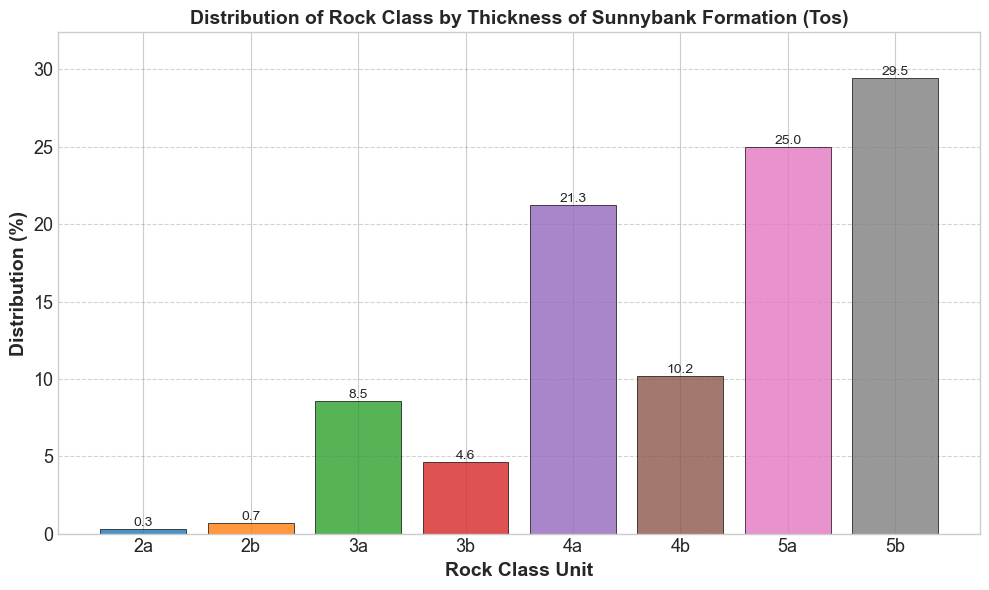

--- Plotting finished ---


In [133]:
plot_category_by_thickness(Tos, 
                           value_col='thickness_proportion_%', 
                           category_col='Consistency', 
                           x_axis_sort = 'alphabetical',
                           tick_fontsize = 13,
                           bar_alpha=0.8, 
                           bar_width = 0.8,
                           show_legend=False,
                           figsize = (10,6),
                           xlabel='Rock Class Unit', 
                           ylabel='Distribution (%)',
                           axis_style={'xlabel_fontsize': 14, 'ylabel_fontsize': 14}, 
                           title="Distribution of Rock Class by Thickness of Sunnybank Formation (Tos)", 
                           output_filepath=f"{output_folder}/Distribution of rock class by thickness - Tos.png")

#### 3.62 Distribution of Rock Class by Thickness of Woogaroo Subgroup (Rjbw)

In [135]:
Rjbw = Rjbw_BH_interp.pivot_table(values='Thickness', index="Consistency", aggfunc='sum').reset_index()
Rjbw.insert(loc=1, column='thickness_proportion_%', value=(Rjbw['Thickness']/Rjbw['Thickness'].sum())*100)
Rjbw

Consistency  thickness_proportion_%  Thickness
0          2a               26.586884      32.88
1          3a               31.689173      39.19
2          3b                1.212905       1.50
3          4a               19.446915      24.05
4          4b                6.549689       8.10
5          5a               10.568448      13.07
6          5b                3.945985       4.88

Processing 7 categories
Plot saved to: Output/2025626_1h/Distribution of rock class by thickness - Rjbw.png


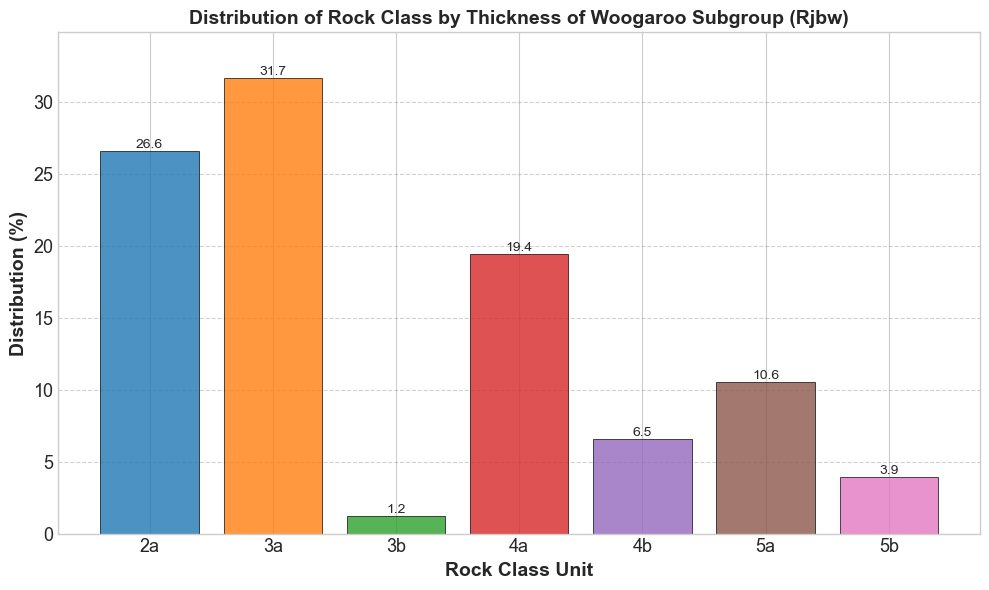

--- Plotting finished ---


In [137]:
plot_category_by_thickness(Rjbw, 
                           value_col='thickness_proportion_%', 
                           category_col='Consistency', 
                           x_axis_sort = 'alphabetical',
                           tick_fontsize = 13,
                           bar_alpha=0.8, 
                           bar_width = 0.8,
                           show_legend=False,
                           figsize = (10,6),
                           xlabel='Rock Class Unit', 
                           ylabel='Distribution (%)',
                           axis_style={'xlabel_fontsize': 14, 'ylabel_fontsize': 14}, 
                           title="Distribution of Rock Class by Thickness of Woogaroo Subgroup (Rjbw)", 
                           output_filepath=f"{output_folder}/Distribution of rock class by thickness - Rjbw.png")

#### 3.63 Distribution of Rock Class by Thickness of Tingalpa Formation (Rin)

In [139]:
Rin_BH_interp.reset_index(drop=True)

Hole_ID  From_mbgl  To_mbgl  Thickness Geology_Orgin Consistency  \
0         BH-07       3.11     5.55       2.44           Rin          5a   
1         BH-07       5.55     9.10       3.55           Rin          4a   
2         BH-07       9.10    14.45       5.35           Rin          3a   
3         BH-07      14.45    18.11       3.66           Rin          2a   
4         BH-08       3.30     6.80       3.50           Rin          5a   
..          ...        ...      ...        ...           ...         ...   
95   HIS-SC-BH8      14.20    15.60       1.40           Rin          5b   
96  HIS-LLS-BH1       5.40     7.60       2.20           Rin          5a   
97  HIS-LLS-BH3       6.80     8.90       2.10           Rin          5a   
98  HIS-LLS-BH4       6.90     8.90       2.00           Rin          5b   
99  HIS-LLS-BH6       9.50    11.30       1.80           Rin          5a   

                    Report  
0    DTMR GFR_FG23024-R4.0  
1    DTMR GFR_FG23024-R4.0  
2    DTMR GFR_FG23024-R4.0  
3    DTMR GFR_FG23024-R4.0  
4    DTMR GFR_FG23024-R4.0  
..                     ...  
95  QR Historical Drawings  
96  QR Historical Drawings  
97  QR Historical Drawings  
98  QR Historical Drawings  
99  QR Historical Drawings  

[100 rows x 7 columns]

In [140]:
Rin_BH_interp['Report'].value_counts()

Report
DTMR GFR_FG23024-R4.0          68
GHD-Mott MacDonald AGS File    19
QR Historical Drawings         13
Name: count, dtype: int64

In [141]:
Rin = Rin_BH_interp.pivot_table(values='Thickness', index="Consistency", aggfunc='sum').reset_index()
Rin.insert(loc=1, column='thickness_proportion_%', value=(Rin['Thickness']/Rin['Thickness'].sum())*100)
Rin

Consistency  thickness_proportion_%  Thickness
0          1a                2.436018       4.15
1          2a               12.954919      22.07
2          2b                2.494717       4.25
3          3a               13.571261      23.12
4          3b                5.881662      10.02
5          4a               12.872740      21.93
6          4b               16.570791      28.23
7          5a               16.606011      28.29
8          5b               16.611881      28.30

Processing 9 categories
Plot saved to: Output/2025626_1h/Distribution of rock class by thickness - Rin.png


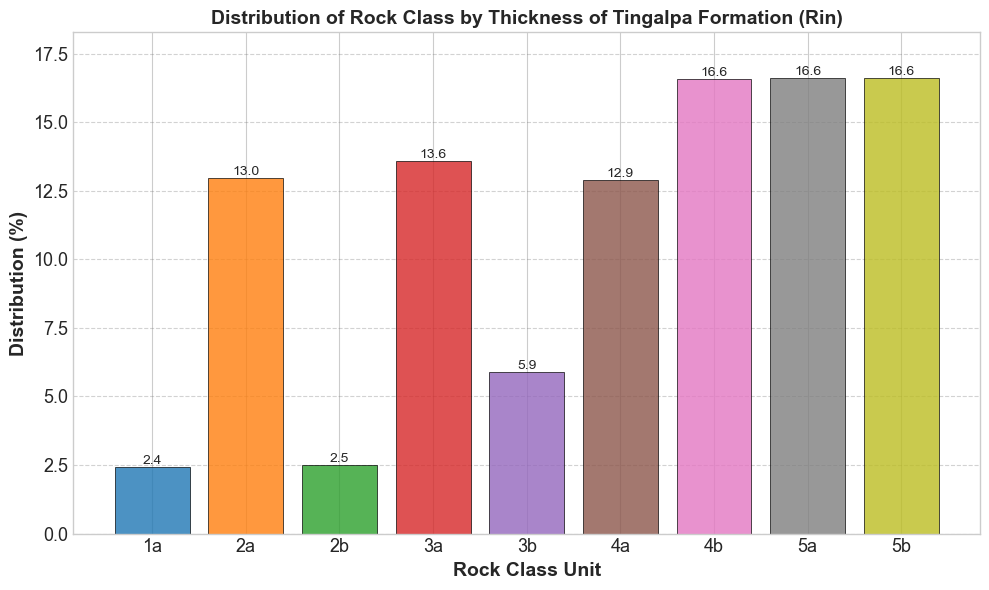

--- Plotting finished ---


In [142]:
plot_category_by_thickness(Rin, 
                           value_col='thickness_proportion_%', 
                           category_col='Consistency', 
                           x_axis_sort = 'alphabetical',
                           tick_fontsize = 13,
                           bar_alpha=0.8, 
                           bar_width = 0.8,
                           show_legend=False,
                           figsize = (10,6),
                           xlabel='Rock Class Unit', 
                           ylabel='Distribution (%)',
                           axis_style={'xlabel_fontsize': 14, 'ylabel_fontsize': 14}, 
                           title="Distribution of Rock Class by Thickness of Tingalpa Formation (Rin)", 
                           output_filepath=f"{output_folder}/Distribution of rock class by thickness - Rin.png")

#### 3.64 Distribution of Rock Class by Thickness of Neranleigh Fernvale Beds (DCf)

In [144]:
Dcf = Dcf_BH_interp.pivot_table(values='Thickness', index="Consistency", aggfunc='sum').reset_index()
Dcf.insert(loc=1, column='thickness_proportion_%', value=(Dcf['Thickness']/Dcf['Thickness'].sum())*100)
Dcf

Consistency  thickness_proportion_%  Thickness
0          1a                2.016242      14.40
1          1b                0.420050       3.00
2          2a               20.247830     144.61
3          2b                7.735928      55.25
4          3a               12.031644      85.93
5          3b               11.999440      85.70
6          4a                5.820498      41.57
7          4b               13.239989      94.56
8          5a                6.676001      47.68
9          5b               19.812377     141.50

Processing 10 categories
Plot saved to: Output/2025626_1h/Distribution of rock class by thickness - Dcf.png


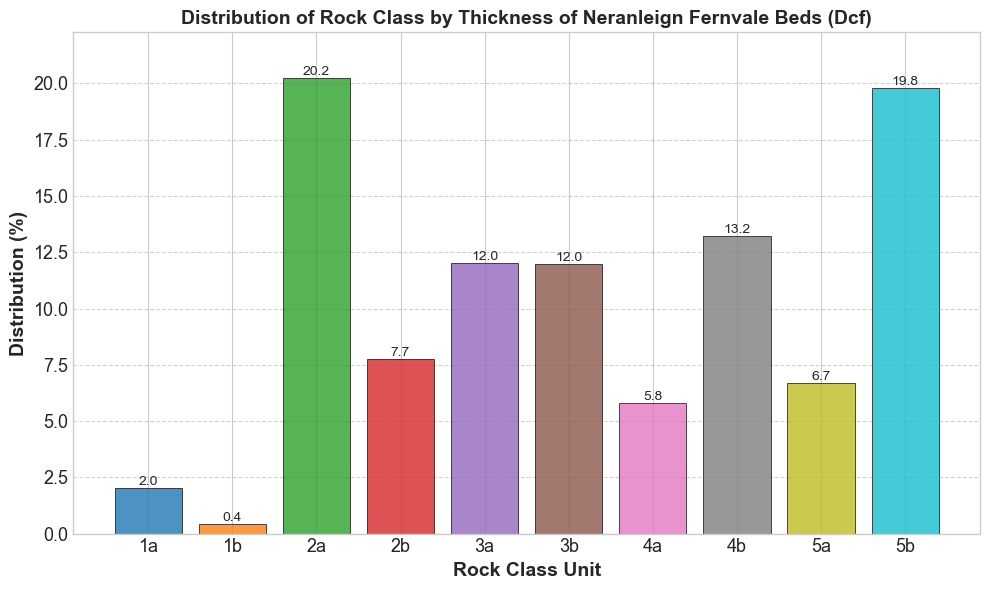

--- Plotting finished ---


In [145]:
plot_category_by_thickness(Dcf, 
                           value_col='thickness_proportion_%', 
                           category_col='Consistency', 
                           x_axis_sort = 'alphabetical',
                           tick_fontsize = 13,
                           bar_alpha=0.8, 
                           bar_width = 0.8,
                           show_legend=False,
                           figsize = (10,6),
                           xlabel='Rock Class Unit', 
                           ylabel='Distribution (%)',
                           axis_style={'xlabel_fontsize': 14, 'ylabel_fontsize': 14}, 
                           title="Distribution of Rock Class by Thickness of Neranleign Fernvale Beds (Dcf)", 
                           output_filepath=f"{output_folder}/Distribution of rock class by thickness - Dcf.png")

### 3.7 CBR swell and WPI histogram plots

In [147]:
WPI_GIR = WPI_final.copy()
CBR_GIR = CBR_final.copy()

WPI_GIR.insert(loc=len(WPI_GIR.columns.to_list()), column='category', value=None)
WPI_GIR.loc[WPI_GIR['WPI']>4200, 'category'] = 'Extreme'
WPI_GIR.loc[WPI_GIR['WPI'].between(3200,4200), 'category'] = 'Very high'
WPI_GIR.loc[WPI_GIR['WPI'].between(2200,3200), 'category'] = 'High'
WPI_GIR.loc[WPI_GIR['WPI'].between(1200,2200), 'category'] = 'Moderate'
WPI_GIR.loc[WPI_GIR['WPI']<=1200, 'category'] = 'Low'

WPI_GIR = WPI_GIR[['Geology_Orgin', 'category']].dropna(how='any')
WPI_GIR.insert(loc=0, column='Name', value='WPI')
WPI_GIR.head()

CBR_GIR = CBR_final.copy()
CBR_GIR.insert(loc=len(CBR_GIR.columns.to_list()), column='category', value=None)
CBR_GIR.loc[CBR_GIR['CBR Swell (%)']>10, 'category'] = 'Extreme'
CBR_GIR.loc[CBR_GIR['CBR Swell (%)'].between(5,10), 'category'] = 'Very high'
CBR_GIR.loc[CBR_GIR['CBR Swell (%)'].between(2.5,5), 'category'] = 'High'
CBR_GIR.loc[CBR_GIR['CBR Swell (%)'].between(0.5,2.5), 'category'] = 'Moderate'
CBR_GIR.loc[CBR_GIR['CBR Swell (%)']<=0.5, 'category'] = 'Low'

CBR_GIR = CBR_GIR[['Geology_Orgin', 'category']].dropna(how='any')
CBR_GIR.insert(loc=0, column='Name', value='CBR Swell (%)')
CBR_GIR.head()

combined_WPI_CBR_GIR = pd.concat([WPI_GIR, CBR_GIR], ignore_index=True)
combined_WPI_CBR_GIR

Name                  Geology_Orgin   category
0              WPI  Residual to Extreme Weathered   Moderate
1              WPI  Residual to Extreme Weathered        Low
2              WPI                          RS_XW  Very high
3              WPI                       ALLUVIUM    Extreme
4              WPI  Residual to Extreme Weathered    Extreme
..             ...                            ...        ...
283  CBR Swell (%)                       ALLUVIUM   Moderate
284  CBR Swell (%)                       ALLUVIUM   Moderate
285  CBR Swell (%)                           FILL   Moderate
286  CBR Swell (%)                           FILL   Moderate
287  CBR Swell (%)                           FILL   Moderate

[288 rows x 3 columns]

INFO: Using 'Geology_Orgin' for stacking (matched from 'Geology_Orgin')
INFO: Setting shared Y-axis limit to: 69.30
Plot saved to: Output/2025626_1h/CBR_swell and WPI (Classification of expansive soil) - Project Wide.png


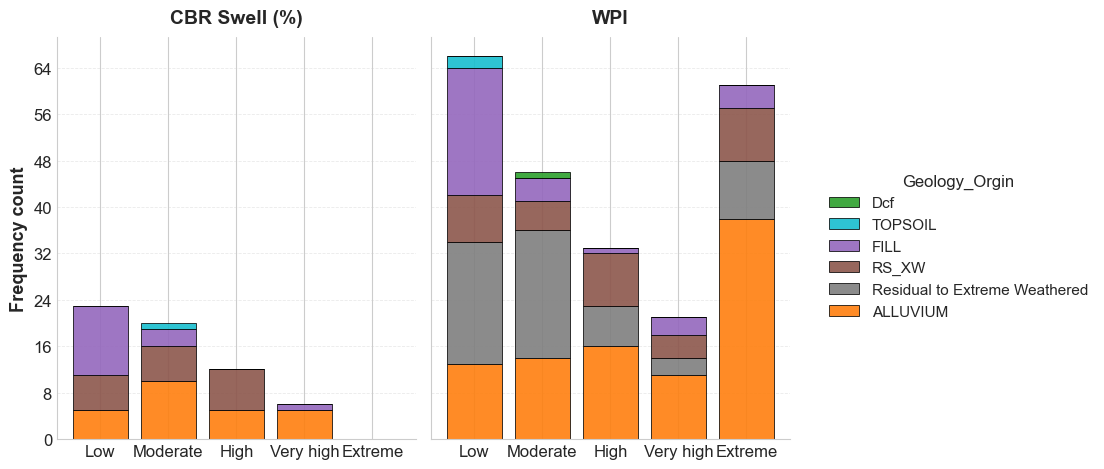

--- Plotting finished for Name ---


In [148]:
ordered_cats = ['Low','Moderate','High','Very high','Extreme']
plot_CBR_swell_WPI_histogram(data_df=combined_WPI_CBR_GIR, 
                             stack_col='Geology_Orgin', 
                             category_order=ordered_cats, 
                             output_filepath=f"{output_folder}/CBR_swell and WPI (Classification of expansive soil) - Project Wide.png")

### 3.8 Rock Strength Analysis

Unconfined compressive strength testing for rock engineering and excavation planning.

#### 3.81 Dcf - Neranleigh - fernvale beds

INFO: Removed 1 rows with missing depth/UCS data.
Plot saved to: Output/2025626_1h/UCS vs Depth - Dcf.png


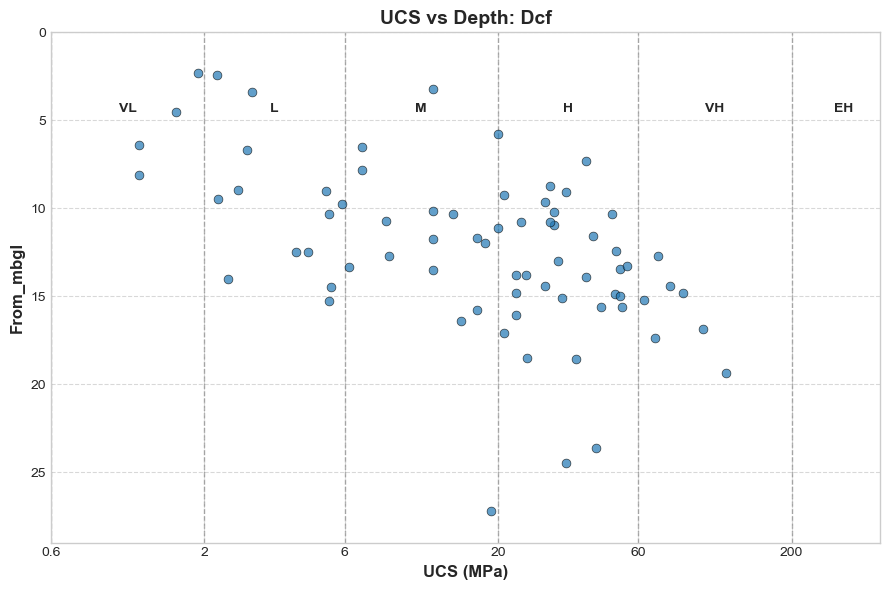

--- UCS vs Depth plotting finished ---


In [152]:
UCS_Dcf = UCS_final.groupby('Geology_Orgin').get_group('Dcf')

plot_UCS_vs_depth(df=UCS_Dcf, 
                  xlim=(0.6, 400), 
                  ylim=(0,29), 
                  title_suffix=' Dcf',
                  show_strength_indicators=True, 
                  strength_indicator_position=0.85,
                  output_filepath=f"{output_folder}/UCS vs Depth - Dcf.png")

#### 3.82 Rin - Tingalpa Formation

INFO: Removed 2 rows with missing depth/UCS data.
Plot saved to: Output/2025626_1h/UCS vs Depth - Rin.png


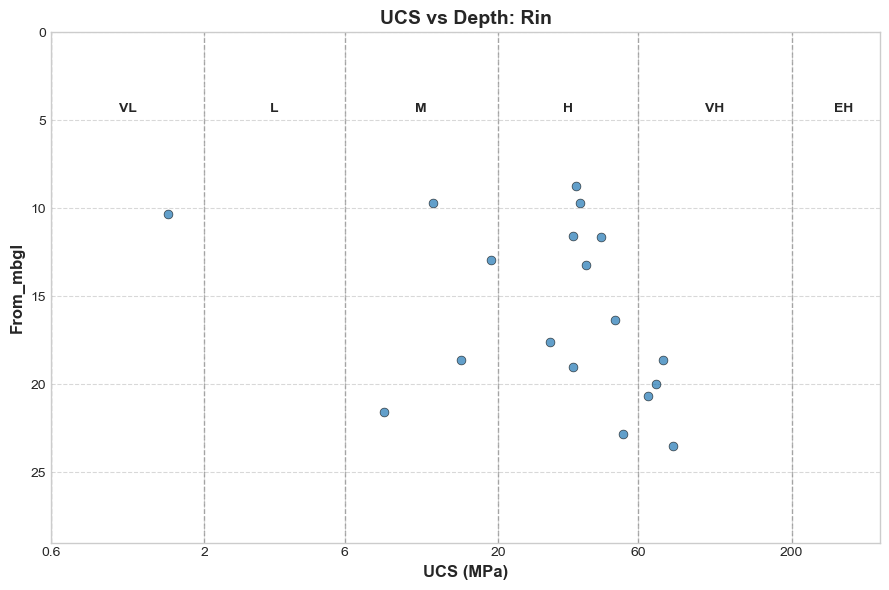

--- UCS vs Depth plotting finished ---


In [154]:
UCS_Rin = UCS_final.groupby('Geology_Orgin').get_group('Rin')

plot_UCS_vs_depth(df=UCS_Rin, 
                  xlim=(0.6, 400), 
                  ylim=(0,29), 
                  title_suffix=' Rin',
                  show_strength_indicators=True, 
                  strength_indicator_position=0.85,
                  output_filepath=f"{output_folder}/UCS vs Depth - Rin.png")

#### 3.83 Rjbw - Woogaroo Subgroup

Plot saved to: Output/2025626_1h/UCS vs Depth - Rjbw.png


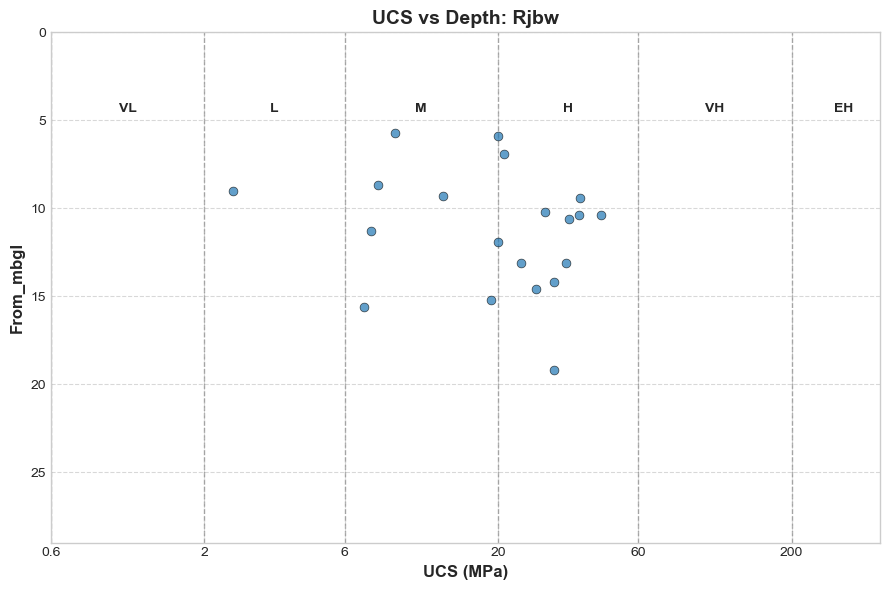

--- UCS vs Depth plotting finished ---


In [156]:
UCS_Rjwb = UCS_final.groupby('Geology_Orgin').get_group('Rjbw')

plot_UCS_vs_depth(df=UCS_Rjwb, 
                  xlim=(0.6, 400), 
                  ylim=(0,29), 
                  title_suffix=' Rjbw',
                  show_strength_indicators=True, 
                  strength_indicator_position=0.85,
                  output_filepath=f"{output_folder}/UCS vs Depth - Rjbw.png")

#### 3.84 Tos - Sunnybank Formation

Plot saved to: Output/2025626_1h/UCS vs Depth - Tos.png


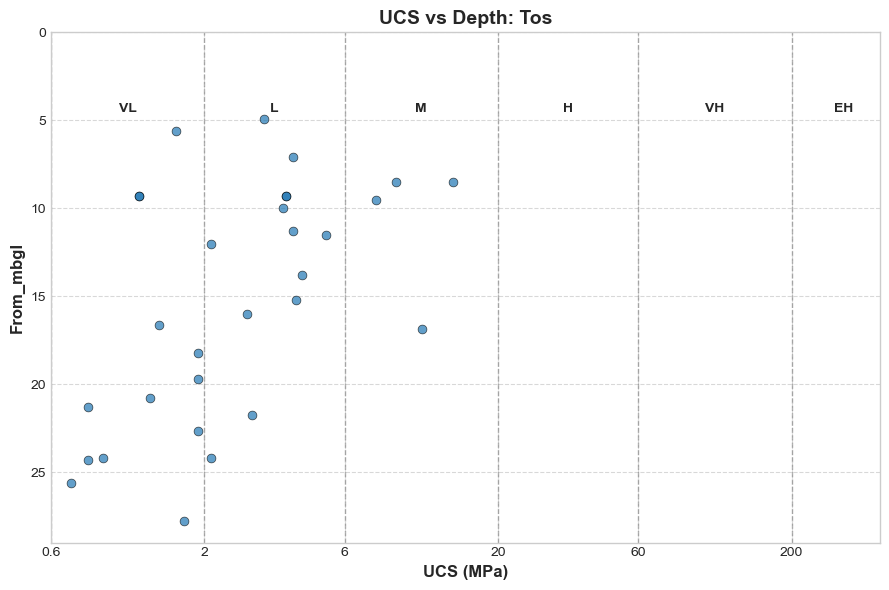

--- UCS vs Depth plotting finished ---


In [158]:
UCS_Tos = UCS_final.groupby('Geology_Orgin').get_group('Tos')

plot_UCS_vs_depth(df=UCS_Tos, 
                  xlim=(0.6, 400), 
                  ylim=(0,29), 
                  title_suffix=' Tos',
                  show_strength_indicators=True, 
                  strength_indicator_position=0.85,
                  output_filepath=f"{output_folder}/UCS vs Depth - Tos.png")

### 3.9 Rock Strength Correlations

Correlation analysis between UCS and point load index for rock classification and design parameters.

In [160]:
UCS_final['Geology_Orgin'].value_counts()

Geology_Orgin
Dcf     73
Tos     40
Rin     21
Rjbw    20
Toc      8
Name: count, dtype: int64

#### 3.91 UCS vs Is(50) axial

In [162]:
UCS_final.columns

Index(['Hole_ID', 'Type', 'From_mbgl', 'To_mbgl', 'Chainage',
       'Surface RL (m AHD)', 'BH Depth (m)', 'Geology_Orgin', 'Map_symbol',
       'Consistency', 'Report', 'UCS?', 'Geological_unit_UCS', 'UCS (MPa)',
       'Is50d (MPa)', 'Is50a (MPa)', 'Is50 Failure Mode', 'Core Rec (%)',
       'RQD (%)', 'Defect Spacing', 'Intact Strength', 'Weathering', 'Rock',
       'Rock color'],
      dtype='object')

Plot successfully saved to: Output/2025626_1h/UCS_Is50 Axial.png


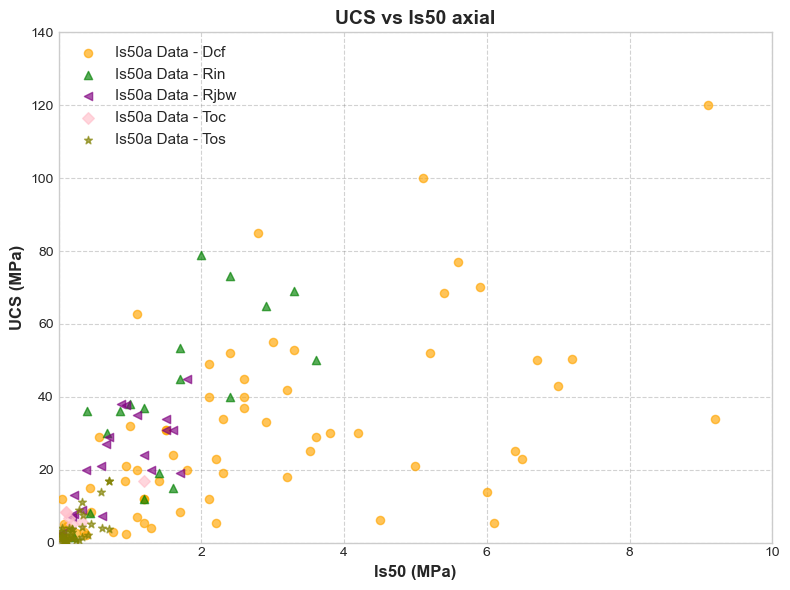

In [163]:
datasets = [{
            'data_df': UCS_final, 
            'x_col': 'Is50a (MPa)', 
            'y_col': 'UCS (MPa)', 
            
}]

plot_UCS_Is50(datasets, 
              title="UCS vs Is50 axial", 
              show_trendlines=False, 
              category_by='Geology_Orgin', 
              xlim=(0,10), 
              ylim=(0,140), 
              xtick_interval=2,
              ytick_interval=20,
              figsize=(8,6),
              output_filepath=f"{output_folder}/UCS_Is50 Axial.png")

#### 3.92 UCS vs Is(50) diametral

Plot successfully saved to: Output/2025626_1h/UCS_Is50 diametral.png


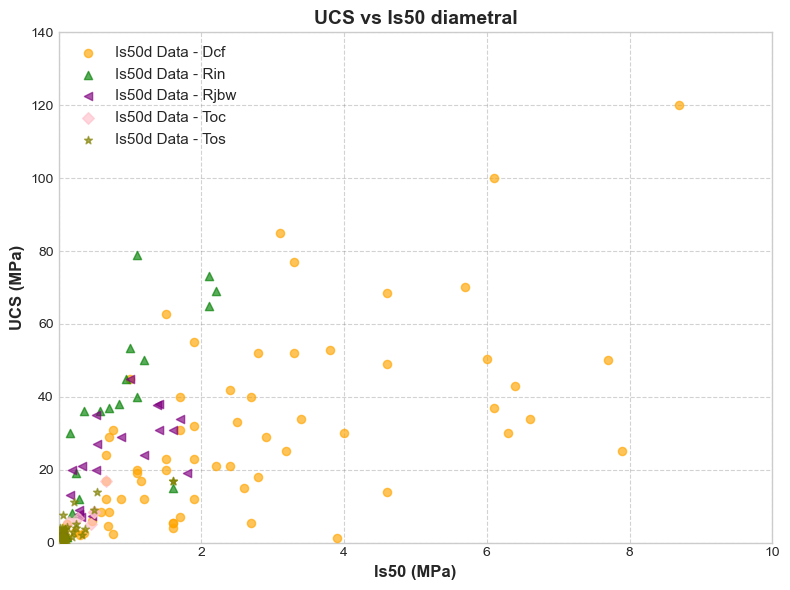

In [165]:
UCS_final.head(2)

datasets = [{
            'data_df': UCS_final, 
            'x_col': 'Is50d (MPa)', 
            'y_col': 'UCS (MPa)',           
}]

# plot_UCS_Is50(datasets, show_trendlines=False, title="UCS vs Is50 diametral", output_filepath=f"{output_folder}/UCS_Is50 Diametral.png")

plot_UCS_Is50(datasets, 
              title="UCS vs Is50 diametral", 
              show_trendlines=False, 
              category_by='Geology_Orgin', 
              xlim=(0,10), 
              ylim=(0,140), 
              xtick_interval=2, 
              ytick_interval=20,
              figsize=(8,6),
              output_filepath=f"{output_folder}/UCS_Is50 diametral.png")

#### 3.93 UCS vs Is(50) - Dcf

Plot successfully saved to: Output/2025626_1h/UCS_Is50 correlation - Dcf.png


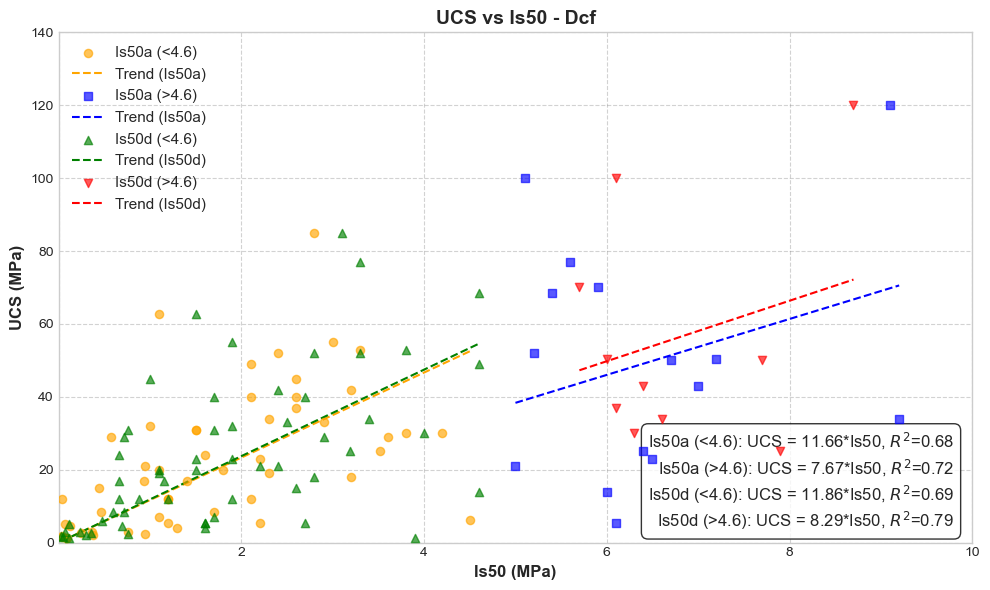

In [167]:
UCS_Dcf = UCS_final.groupby('Geology_Orgin').get_group('Dcf')
UCS_Dcf_Is50a_less_4_6 = UCS_Dcf[UCS_Dcf['Is50a (MPa)'] <= 4.6]
UCS_Dcf_Is50a_larger_4_6 = UCS_Dcf[UCS_Dcf['Is50a (MPa)'] > 4.6]
UCS_Dcf_Is50d_less_4_6 = UCS_Dcf[UCS_Dcf['Is50d (MPa)'] <= 4.6]
UCS_Dcf_Is50d_larger_4_6 = UCS_Dcf[UCS_Dcf['Is50d (MPa)'] > 4.6]

# New multiple DataFrame format - each dataset specifies its own DataFrame and columns
datasets = [
    {
        'data_df': UCS_Dcf_Is50a_less_4_6, 
        'x_col': 'Is50a (MPa)', 
        'y_col': 'UCS (MPa)', 
        'label': 'Is50a (<4.6)', 
    },
    {
        'data_df': UCS_Dcf_Is50a_larger_4_6, 
        'x_col': 'Is50a (MPa)', 
        'y_col': 'UCS (MPa)', 
        'label': 'Is50a (>4.6)', 
    },
    {
        'data_df': UCS_Dcf_Is50d_less_4_6,
        'x_col': 'Is50d (MPa)', 
        'y_col': 'UCS (MPa)', 
        'label': 'Is50d (<4.6)', 
    },
    {
        'data_df': UCS_Dcf_Is50d_larger_4_6,
        'x_col': 'Is50d (MPa)', 
        'y_col': 'UCS (MPa)', 
        'label': 'Is50d (>4.6)', 
    }
]

plot_UCS_Is50(datasets=datasets,
              xlim=(0, 10), 
              ylim=(0, 140), 
              title='UCS vs Is50 - Dcf', 
              figsize=(10, 6),
              output_filepath=f"{output_folder}/UCS_Is50 correlation - Dcf.png")

#### 3.94 UCS vs Is(50) dual - Rin

Plot successfully saved to: Output/2025626_1h/UCS_Is50 correlation - Rin.png


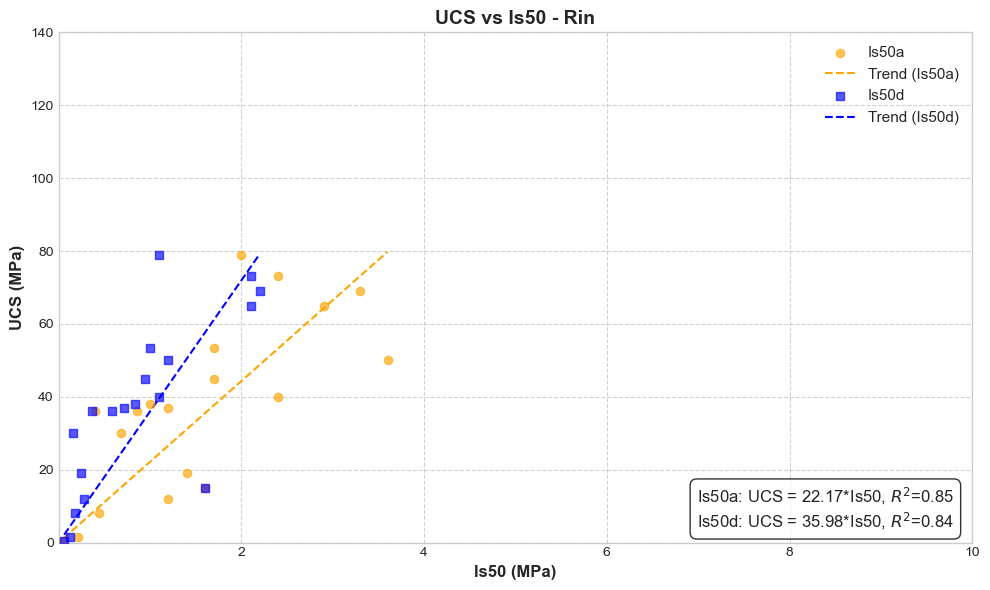

In [169]:
UCS_Rin = UCS_final.groupby('Geology_Orgin').get_group('Rin')

# New multiple DataFrame format - each dataset specifies its own DataFrame and columns
datasets = [
    {
        'data_df': UCS_Rin, 
        'x_col': 'Is50a (MPa)', 
        'y_col': 'UCS (MPa)', 
        'label': 'Is50a', 
        'color': 'orange', 
        'marker': 'o'
    },
    {
        'data_df': UCS_Rin, 
        'x_col': 'Is50d (MPa)', 
        'y_col': 'UCS (MPa)', 
        'label': 'Is50d', 
        'color': 'blue', 
        'marker': 's'
    }
]

plot_UCS_Is50(datasets=datasets,
              xlim=(0, 10), 
              ylim=(0, 140), 
              title='UCS vs Is50 - Rin', 
              figsize=(10, 6),
              output_filepath=f"{output_folder}/UCS_Is50 correlation - Rin.png")

#### 3.95 UCS vs Is(50) dual - Rjwb

Plot successfully saved to: Output/2025626_1h/UCS_Is50 correlation - Rjbw.png


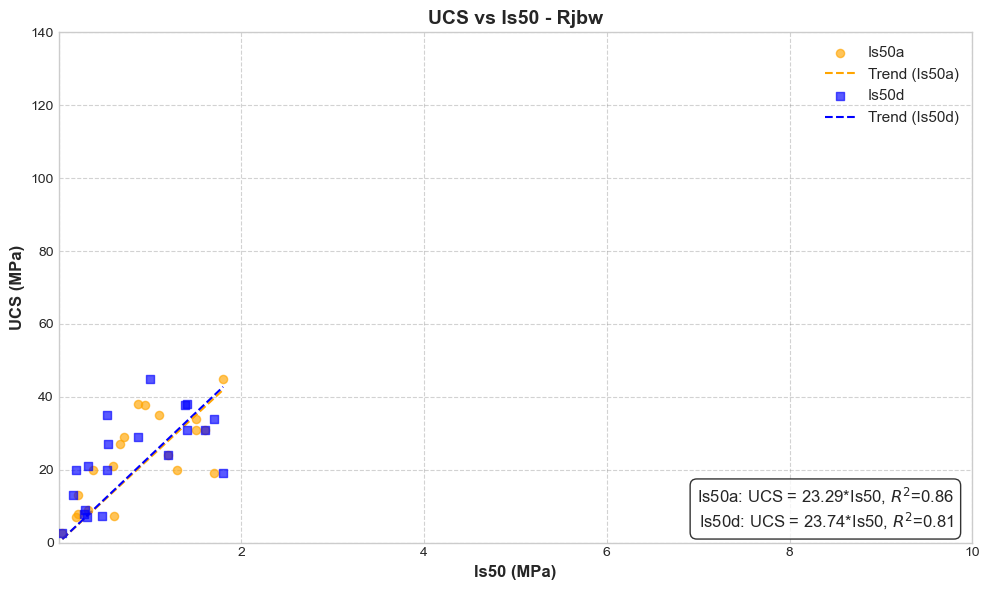

In [171]:
UCS_Rjwb = UCS_final.groupby('Geology_Orgin').get_group('Rjbw')

# New multiple DataFrame format - each dataset specifies its own DataFrame and columns
datasets = [
    {
        'data_df': UCS_Rjwb, 
        'x_col': 'Is50a (MPa)', 
        'y_col': 'UCS (MPa)', 
        'label': 'Is50a', 
        'color': 'orange', 
        'marker': 'o'
    },
    {
        'data_df': UCS_Rjwb, 
        'x_col': 'Is50d (MPa)', 
        'y_col': 'UCS (MPa)', 
        'label': 'Is50d', 
        'color': 'blue', 
        'marker': 's'
    }
]

plot_UCS_Is50(datasets=datasets,
              xlim=(0, 10), 
              ylim=(0, 140), 
              title='UCS vs Is50 - Rjbw', 
              figsize=(10, 6),
              output_filepath=f"{output_folder}/UCS_Is50 correlation - Rjbw.png")

#### 3.96 UCS vs Is(50) dual - Tos

Plot successfully saved to: Output/2025626_1h/UCS_Is50 correlation - Tos.png


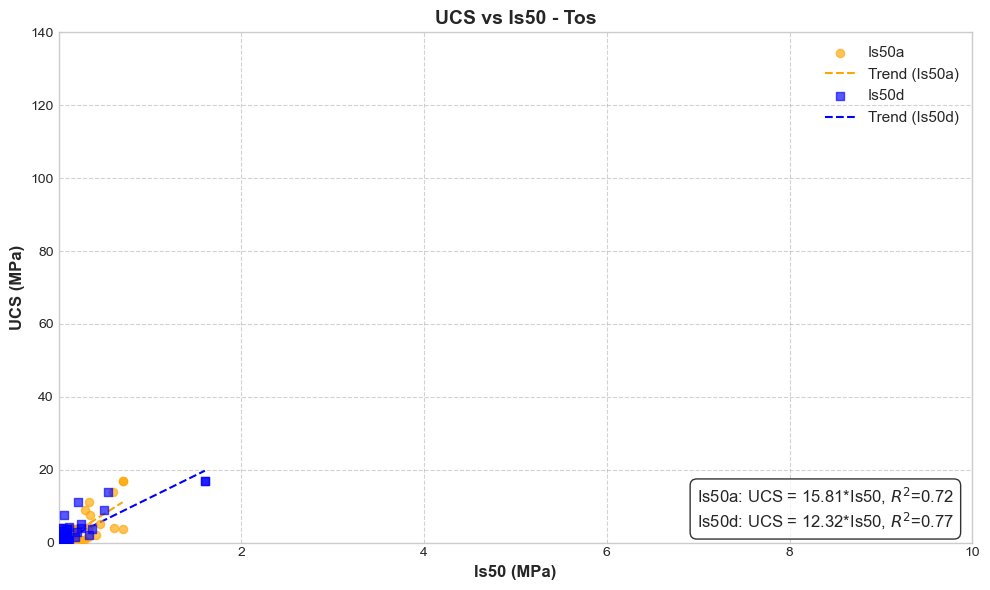

In [173]:
UCS_Tos = UCS_final.groupby('Geology_Orgin').get_group('Tos')

# New multiple DataFrame format - each dataset specifies its own DataFrame and columns
datasets = [
    {
        'data_df': UCS_Tos, 
        'x_col': 'Is50a (MPa)', 
        'y_col': 'UCS (MPa)', 
        'label': 'Is50a', 
        'color': 'orange', 
        'marker': 'o'
    },
    {
        'data_df': UCS_Tos, 
        'x_col': 'Is50d (MPa)', 
        'y_col': 'UCS (MPa)', 
        'label': 'Is50d', 
        'color': 'blue', 
        'marker': 's'
    }
]

plot_UCS_Is50(datasets=datasets,
              xlim=(0, 10), 
              ylim=(0, 140), 
              title='UCS vs Is50 - Tos', 
              figsize=(10, 6),
              output_filepath=f"{output_folder}/UCS_Is50 correlation - Tos.png")

### 3.10 Engineering Properties vs Depth Analysis

Spatial analysis of engineering properties with depth for foundation design and ground improvement assessment.